In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statistics import mean, median
from math import sqrt
from scipy.stats import mannwhitneyu
from typing import Tuple, List, Dict, Set, Iterable
import matplotlib.style as mpl_style
import os
import json


In [3]:
# path to csv results
EC_PATH = "./results.csv"

In [4]:
def df_from_path(path: str) -> pd.DataFrame:
    return pd.read_csv(
        filepath_or_buffer=path,
        sep="?",
    )

EC_RESULTS = df_from_path(EC_PATH)
EC_RESULTS.tail()

directory rund_id  test_no  generation  \
615    dae_gp  7_4097        7          26   
616    dae_gp  7_4097        7          27   
617    dae_gp  7_4097        7          28   
618    dae_gp  7_4097        7          29   
619    dae_gp  7_4097        7          30   

     after_selection_depth_25percentile  after_selection_depth_50percentile  \
615                                 0.0                                 0.0   
616                                 0.0                                 0.0   
617                                 0.0                                 0.0   
618                                 0.0                                 0.0   
619                                 0.0                                 0.0   

     after_selection_depth_75percentile after_selection_depth_algorithm  \
615                                 0.0                        DAE_LSTM   
616                                 0.0                        DAE_LSTM   
617                                 6.0                        DAE_LSTM   
618                                 0.0                        DAE_LSTM   
619                                 1.0                        DAE_LSTM   

     after_selection_depth_avg  \
615                      0.084   
616                      0.238   
617                      2.858   
618                      0.314   
619                      0.526   

     after_selection_depth_avg_lev_distance_denoising  ...  training_error  \
615                                             0.054  ...           0.219   
616                                             0.062  ...           0.193   
617                                             0.400  ...           0.575   
618                                             0.086  ...           0.321   
619                                             0.112  ...           0.209   

     training_errors  training_mode unique  unique_output_vector_rate  \
615             None    convergence    106                      0.176   
616             None    convergence    320                      0.588   
617             None    convergence    109                      0.196   
618             None    convergence    151                      0.268   
619             None    convergence     93                      0.134   

     unique_output_vector_rate_int  unique_output_vector_rate_sel  \
615                          0.144                          0.062   
616                          0.462                          0.104   
617                          0.172                          0.298   
618                          0.194                          0.114   
619                          0.128                          0.154   

    unique_output_vector_rate_test  unique_rate  \
615                          0.176        0.212   
616                          0.588        0.640   
617                          0.196        0.218   
618                          0.268        0.302   
619                          0.134        0.186   

     wass_norm_lev_div_sampled_vs_selected  
615                                  0.108  
616                                  0.098  
617                                  0.047  
618                                   0.02  
619                                   0.02  

[5 rows x 787 columns]

In [5]:
def split_df(df: pd.DataFrame, dir1: str, dir2: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return df.query("directory == @dir1").copy(), df.query("directory == @dir2").copy()
    
pt_results, reg_results = split_df(EC_RESULTS, "pt_dae_gp", "dae_gp")

In [6]:

print(
    pt_results.shape == reg_results.shape,
    pt_results.shape,
    reg_results.shape
)


True (310, 787) (310, 787)


In [7]:
def filter_df_by_headers(df, headers):
    return df[df.columns.intersection(headers)]

In [8]:
def get_test_nums(df) -> Set[int]:
    return {x for x in df.test_no}

pt_test_nums = get_test_nums(pt_results)
reg_test_nums = get_test_nums(reg_results)

def get_rund_ids(df) -> Set[int]:
    return {x for x in df.rund_id}

pt_rund_ids = get_rund_ids(pt_results)
reg_rund_ids = get_rund_ids(reg_results)

PT_NRUNS = len(pt_rund_ids)
REG_NRUNS = len(reg_rund_ids)

print(f"Pre-Trained Runs: {PT_NRUNS}\nRegular Runs: {REG_NRUNS}")

Pre-Trained Runs: 10
Regular Runs: 10


In [9]:
D = {
    "hidden_layers": 2,
    "gen_max": 30,
    "n_runs": 10
}

def validate(D: Dict, df: pd.DataFrame):

    def check_hidden_layers(df: pd.DataFrame, value: str) -> bool:
        return all(df['hidden_layers'] == value)

    print("Correct number of Hidden Layers: ", check_hidden_layers(df, D["hidden_layers"]))


    def check_generations_range(df: pd.DataFrame, minimum: int, maximum: int) -> bool:
        return all(df['generation'] >= minimum) and all(df['generation'] <= maximum)

    print("Correct number of Generations: ", check_generations_range(df, 0, D["gen_max"]))

    def get_ind_rund_ids(df):
        return len({x for x in df.rund_id})

    print("Minimum number of Runs reached: ", get_ind_rund_ids(df) >= D["n_runs"])


print("Regular Results:\n...")
validate(D, reg_results) 
print("\nPre-trained Results:\n...")
validate(D, pt_results)
print()

Regular Results:
...
Correct number of Hidden Layers:  True
Correct number of Generations:  True
Minimum number of Runs reached:  True

Pre-trained Results:
...
Correct number of Hidden Layers:  True
Correct number of Generations:  True
Minimum number of Runs reached:  True



In [36]:
def get_vals(df, vals, gens):

    ret = []

    def filter_df_by_col_val(df, col, val):
        return df[df[col] == val]

    def get_rund_ids(df) -> Set[int]:
        return {x for x in df.rund_id}
    
    run_ids = get_rund_ids(df)

    for i, id in enumerate(run_ids):

        _df = filter_df_by_col_val(df, "rund_id", id)

        ret.append([])

        for gen in range(0,gens+1):

            __df = filter_df_by_col_val(_df, "generation", gen)

            ret[i].append(
                __df[vals].values[0]
            )
    return ret


reg_fits = get_vals(reg_results, "best_fitness", 30)
reg_fits_test = get_vals(reg_results, "best_fitness_test", 30)

pt_fits = get_vals(pt_results, "best_fitness", 30)
pt_fits_test = get_vals(pt_results, "best_fitness_test", 30)


def get_means(arr):

    ret = []

    for gen in range(0, 31):

        gen_fits=[]

        for run in range(0, len(arr)):

            gen_fits.append(arr[run][gen])
    
        ret.append(mean(gen_fits))

    return ret
        


reg_fits_mean = get_means(reg_fits)
reg_fits_test_mean = get_means(reg_fits_test)

pt_fits_mean = get_means(pt_fits)
pt_fits_test_mean = get_means(pt_fits_test)


def get_medians(arr):

    ret = []

    for gen in range(0, 31):

        gen_fits=[]

        for run in range(0, len(arr)):

            gen_fits.append(arr[run][gen])
    
        ret.append(median(gen_fits))

    return ret


reg_fits_med = get_medians(reg_fits)
reg_fits_test_med = get_medians(reg_fits_test)

pt_fits_med = get_medians(pt_fits)
pt_fits_test_med = get_medians(pt_fits_test)

In [11]:
DATAPATH = "/Users/rmn/masterThesis/master_thesis/data/concrete_2hl_FullRun_30gens"

def writeMWU(dir_name: str, file_name:str, sample1: Iterable, sample2: Iterable):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    statistic, pval = mannwhitneyu(x=sample1, y=sample2)

    S = {
        "statistic" : statistic,
        "p-value"   : pval
    }
    print(S)

    json.dump(
        S,
        open(os.path.join(dir_name, f"{file_name}.json"), "w", encoding="utf-8"),
    )

def writeData(dir_name: str, file_name:str, D: Dict):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


    #print(D)

    json.dump(
        D,
        open(os.path.join(dir_name, f"{file_name}.json"), "w", encoding="utf-8"),
    )


In [12]:
from json import load

MPL_CONFIG = load(
    open("/Users/rmn/masterThesis/eda-gp-2020/experiments/matplotlib_config.json", "r", encoding="utf-8")
)


mpl_style.use(MPL_CONFIG["mpl_style"])

# font sizes
SMALL=MPL_CONFIG["fonts"]["small"]
MID=MPL_CONFIG["fonts"]["mid"]
BIG=MPL_CONFIG["fonts"]["big"]

# color codes
C_REG=MPL_CONFIG["colors"]["dae-gp"]
C_PT=MPL_CONFIG["colors"]["pt_dae-gp"]

# marker codes
M_TRAIN=MPL_CONFIG["marker"]["train"]
M_TEST=MPL_CONFIG["marker"]["test"]

TRAIN_LINESTYLE=MPL_CONFIG["train_line_style"]

DPI=MPL_CONFIG["dpi"]


IMG_PATH=f"{MPL_CONFIG['image_base_path']}/concrete_2hl_maxIndSize_fullRun_30gens"

def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

create_dir(IMG_PATH)
BASE_TITLE="Concrete 2 Hidden Layer"

{'statistic': 212.0, 'p-value': 0.00011737449847008001}
{'problem': 'Concrete', 'hiddenLayer': 2, 'DAE-GP (train)': [[22.88218386442024, 22.88218386442024, 22.88218386442024, 22.88218386442024, 22.88218386442024, 19.643896000974127, 19.643896000974127, 19.32276425265698, 19.32276425265698, 17.911625817258347, 17.911625817258347, 17.911625817258347, 17.911625817258347, 17.911625817258347, 17.911625817258347, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237], [20.372624663857646, 20.372624663857646, 20.372624663857646, 20.372624663857646, 20.372624663857646, 18.153720875782096, 18.153720875782096, 18.153720875782096, 16.026683309819703, 16.026683309819703, 16.026683309819703, 16.026683309819703, 16.026683309819703, 16.0266

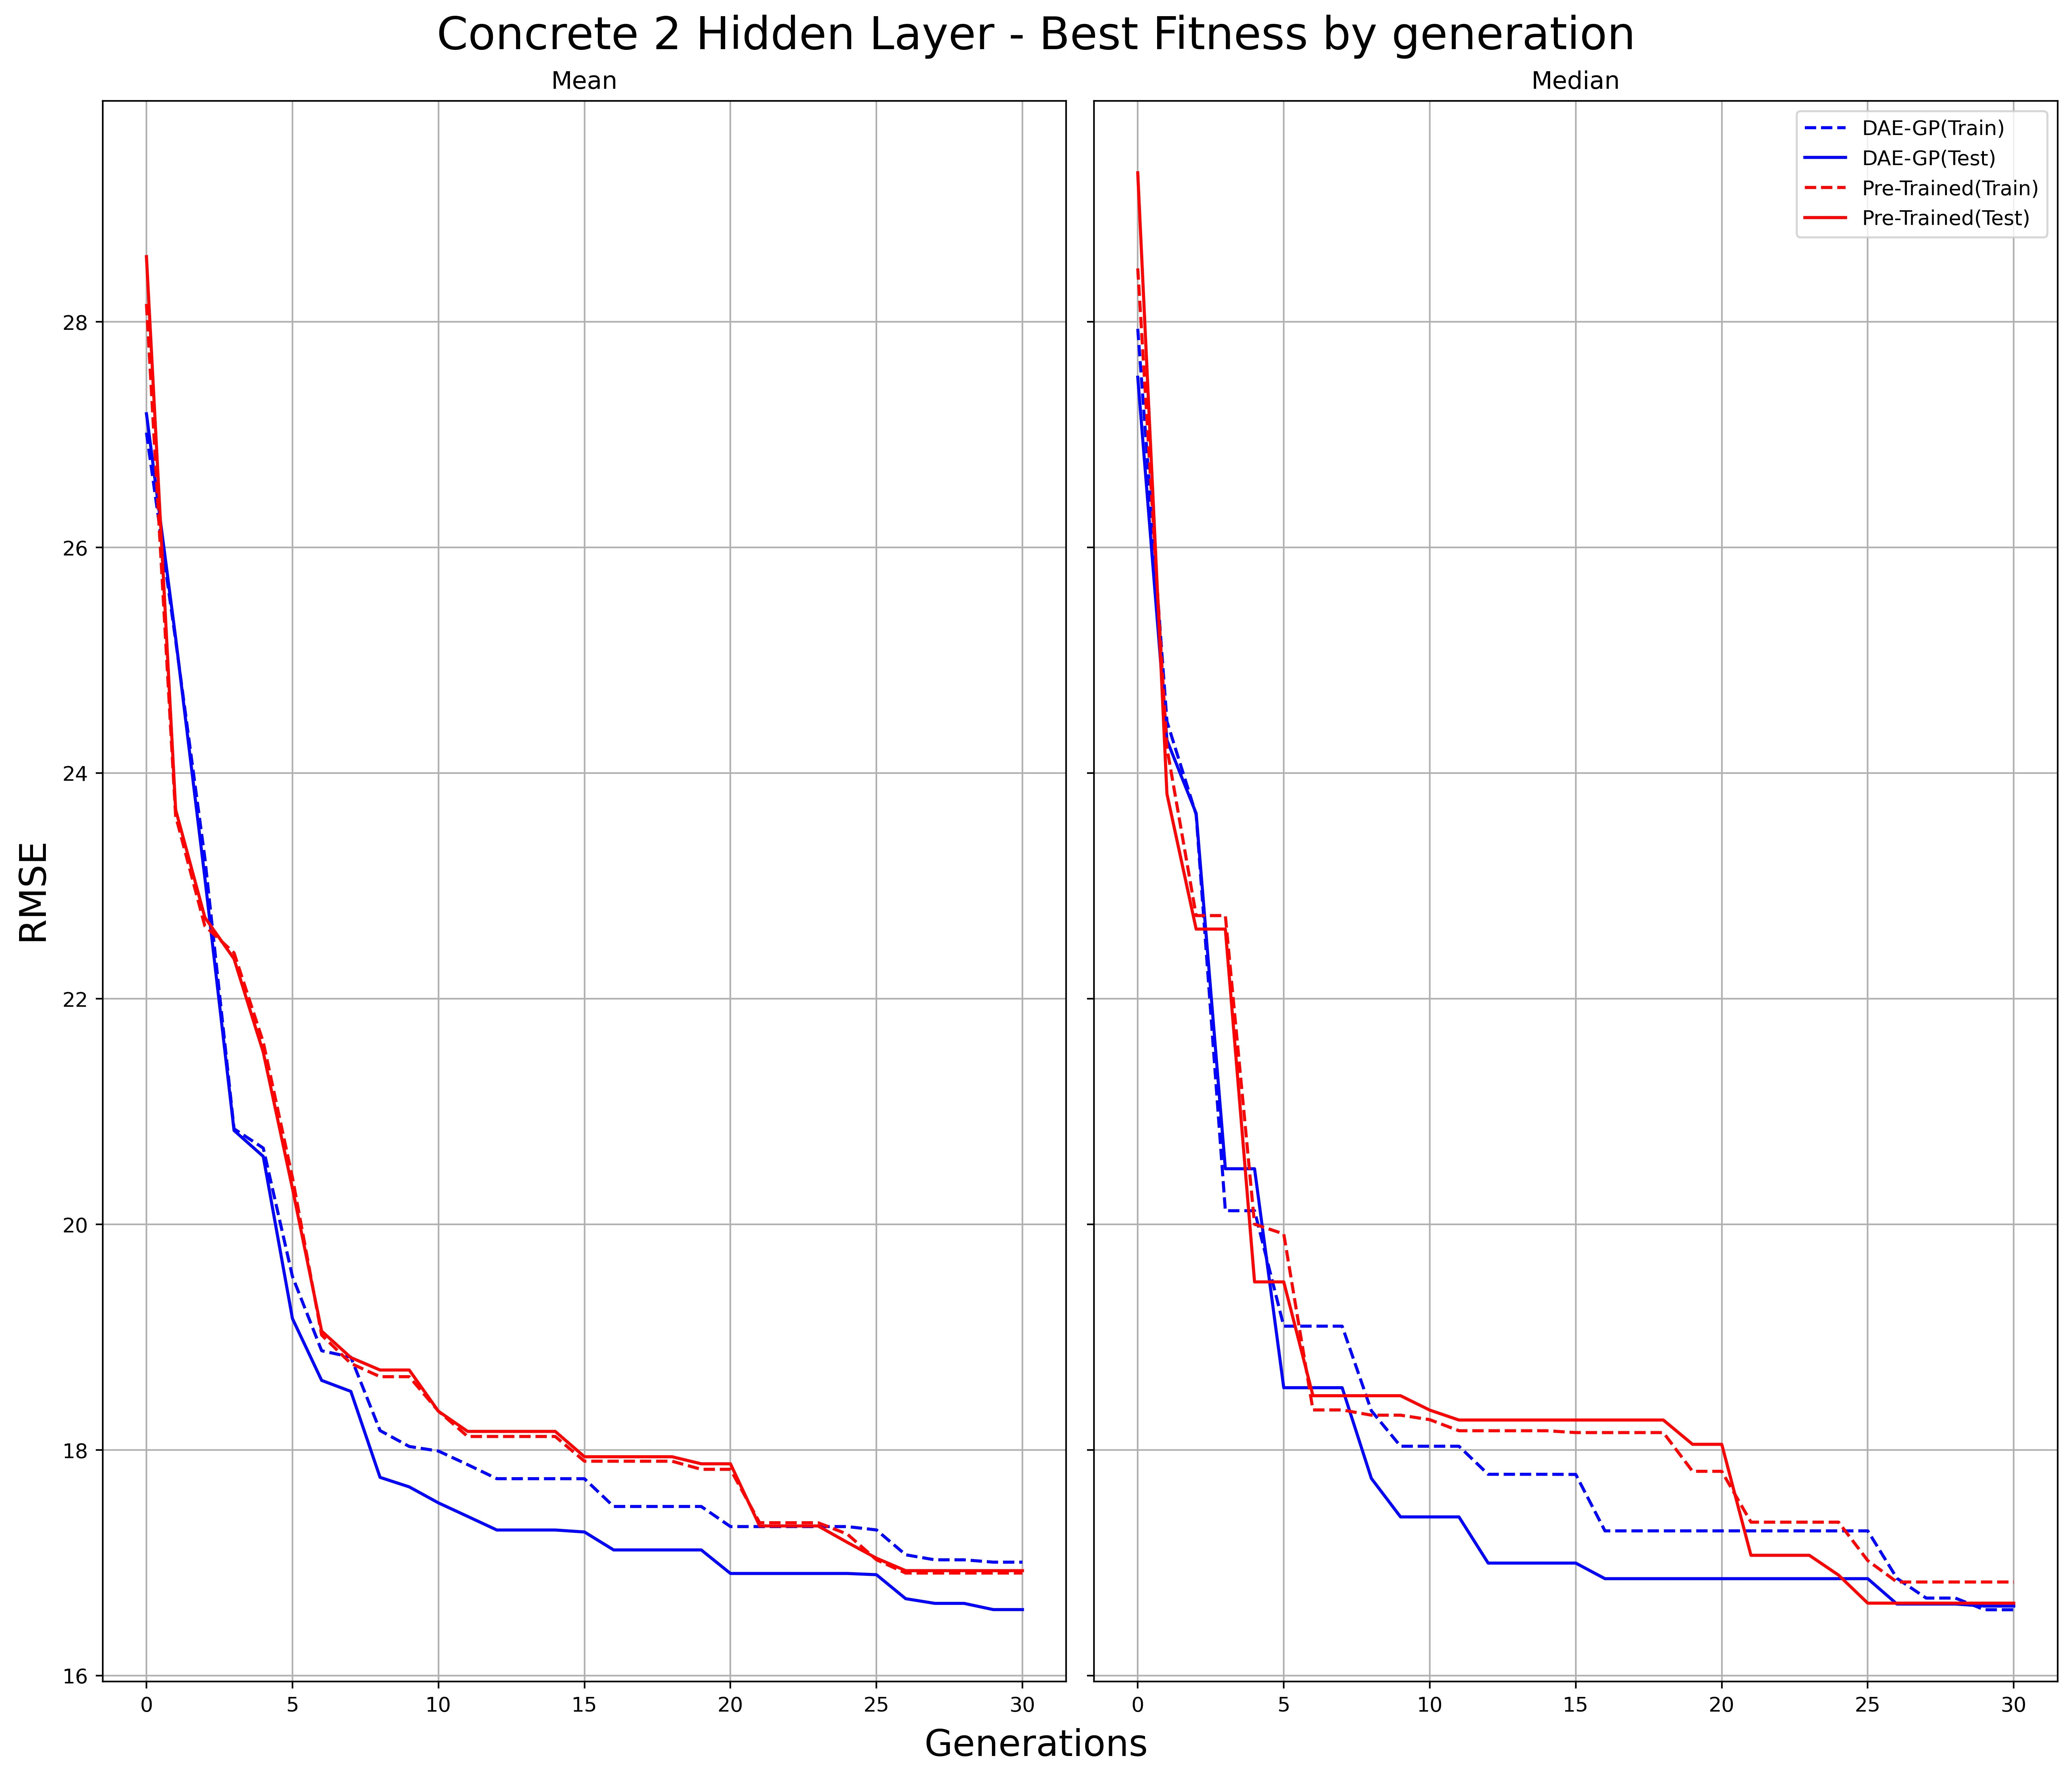

In [33]:
fig, (axl, axr) = plt.subplots(ncols=2, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]



fig.suptitle(f"{BASE_TITLE} - Best Fitness by generation", fontsize=BIG)
fig.supxlabel("Generations", fontsize=MID)
fig.supylabel("RMSE", fontsize=MID)

axl.set_title(f"Mean")
axl.plot(gens, reg_fits_mean, color=C_REG, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Train)")
axl.plot(gens, reg_fits_test_mean, color=C_REG, marker=M_TEST, label="DAE-GP(Test)")
axl.plot(gens, pt_fits_mean, color=C_PT, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Train)")
axl.plot(gens, pt_fits_test_mean, color=C_PT, marker=M_TEST, label="Pre-Trained(Test)")
axl.grid()

axr.set_title("Median")
axr.plot(gens, reg_fits_med, color=C_REG, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Train)")
axr.plot(gens, reg_fits_test_med, color=C_REG, marker=M_TEST, label="DAE-GP(Test)")
axr.plot(gens, pt_fits_med, color=C_PT, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Train)")
axr.plot(gens, pt_fits_test_med, color=C_PT, marker=M_TEST, label="Pre-Trained(Test)")
axr.grid()

axr.legend()


fig.savefig(f"{IMG_PATH}/mean_median_fitness_byGens.png")
writeMWU(DATAPATH, "MWU-BestFitnessByGen", pt_fits[0], reg_fits[0])

D = {
    "problem": "Concrete",
    "hiddenLayer": 2,
    "DAE-GP (train)" : reg_fits,
    "DAE-GP (test)" : reg_fits_test,
    "Pre-Trained (train)" : pt_fits,
    "Pre-Trained (test)" : pt_fits_test
}

writeData(DATAPATH, "full_fitness_data", D)

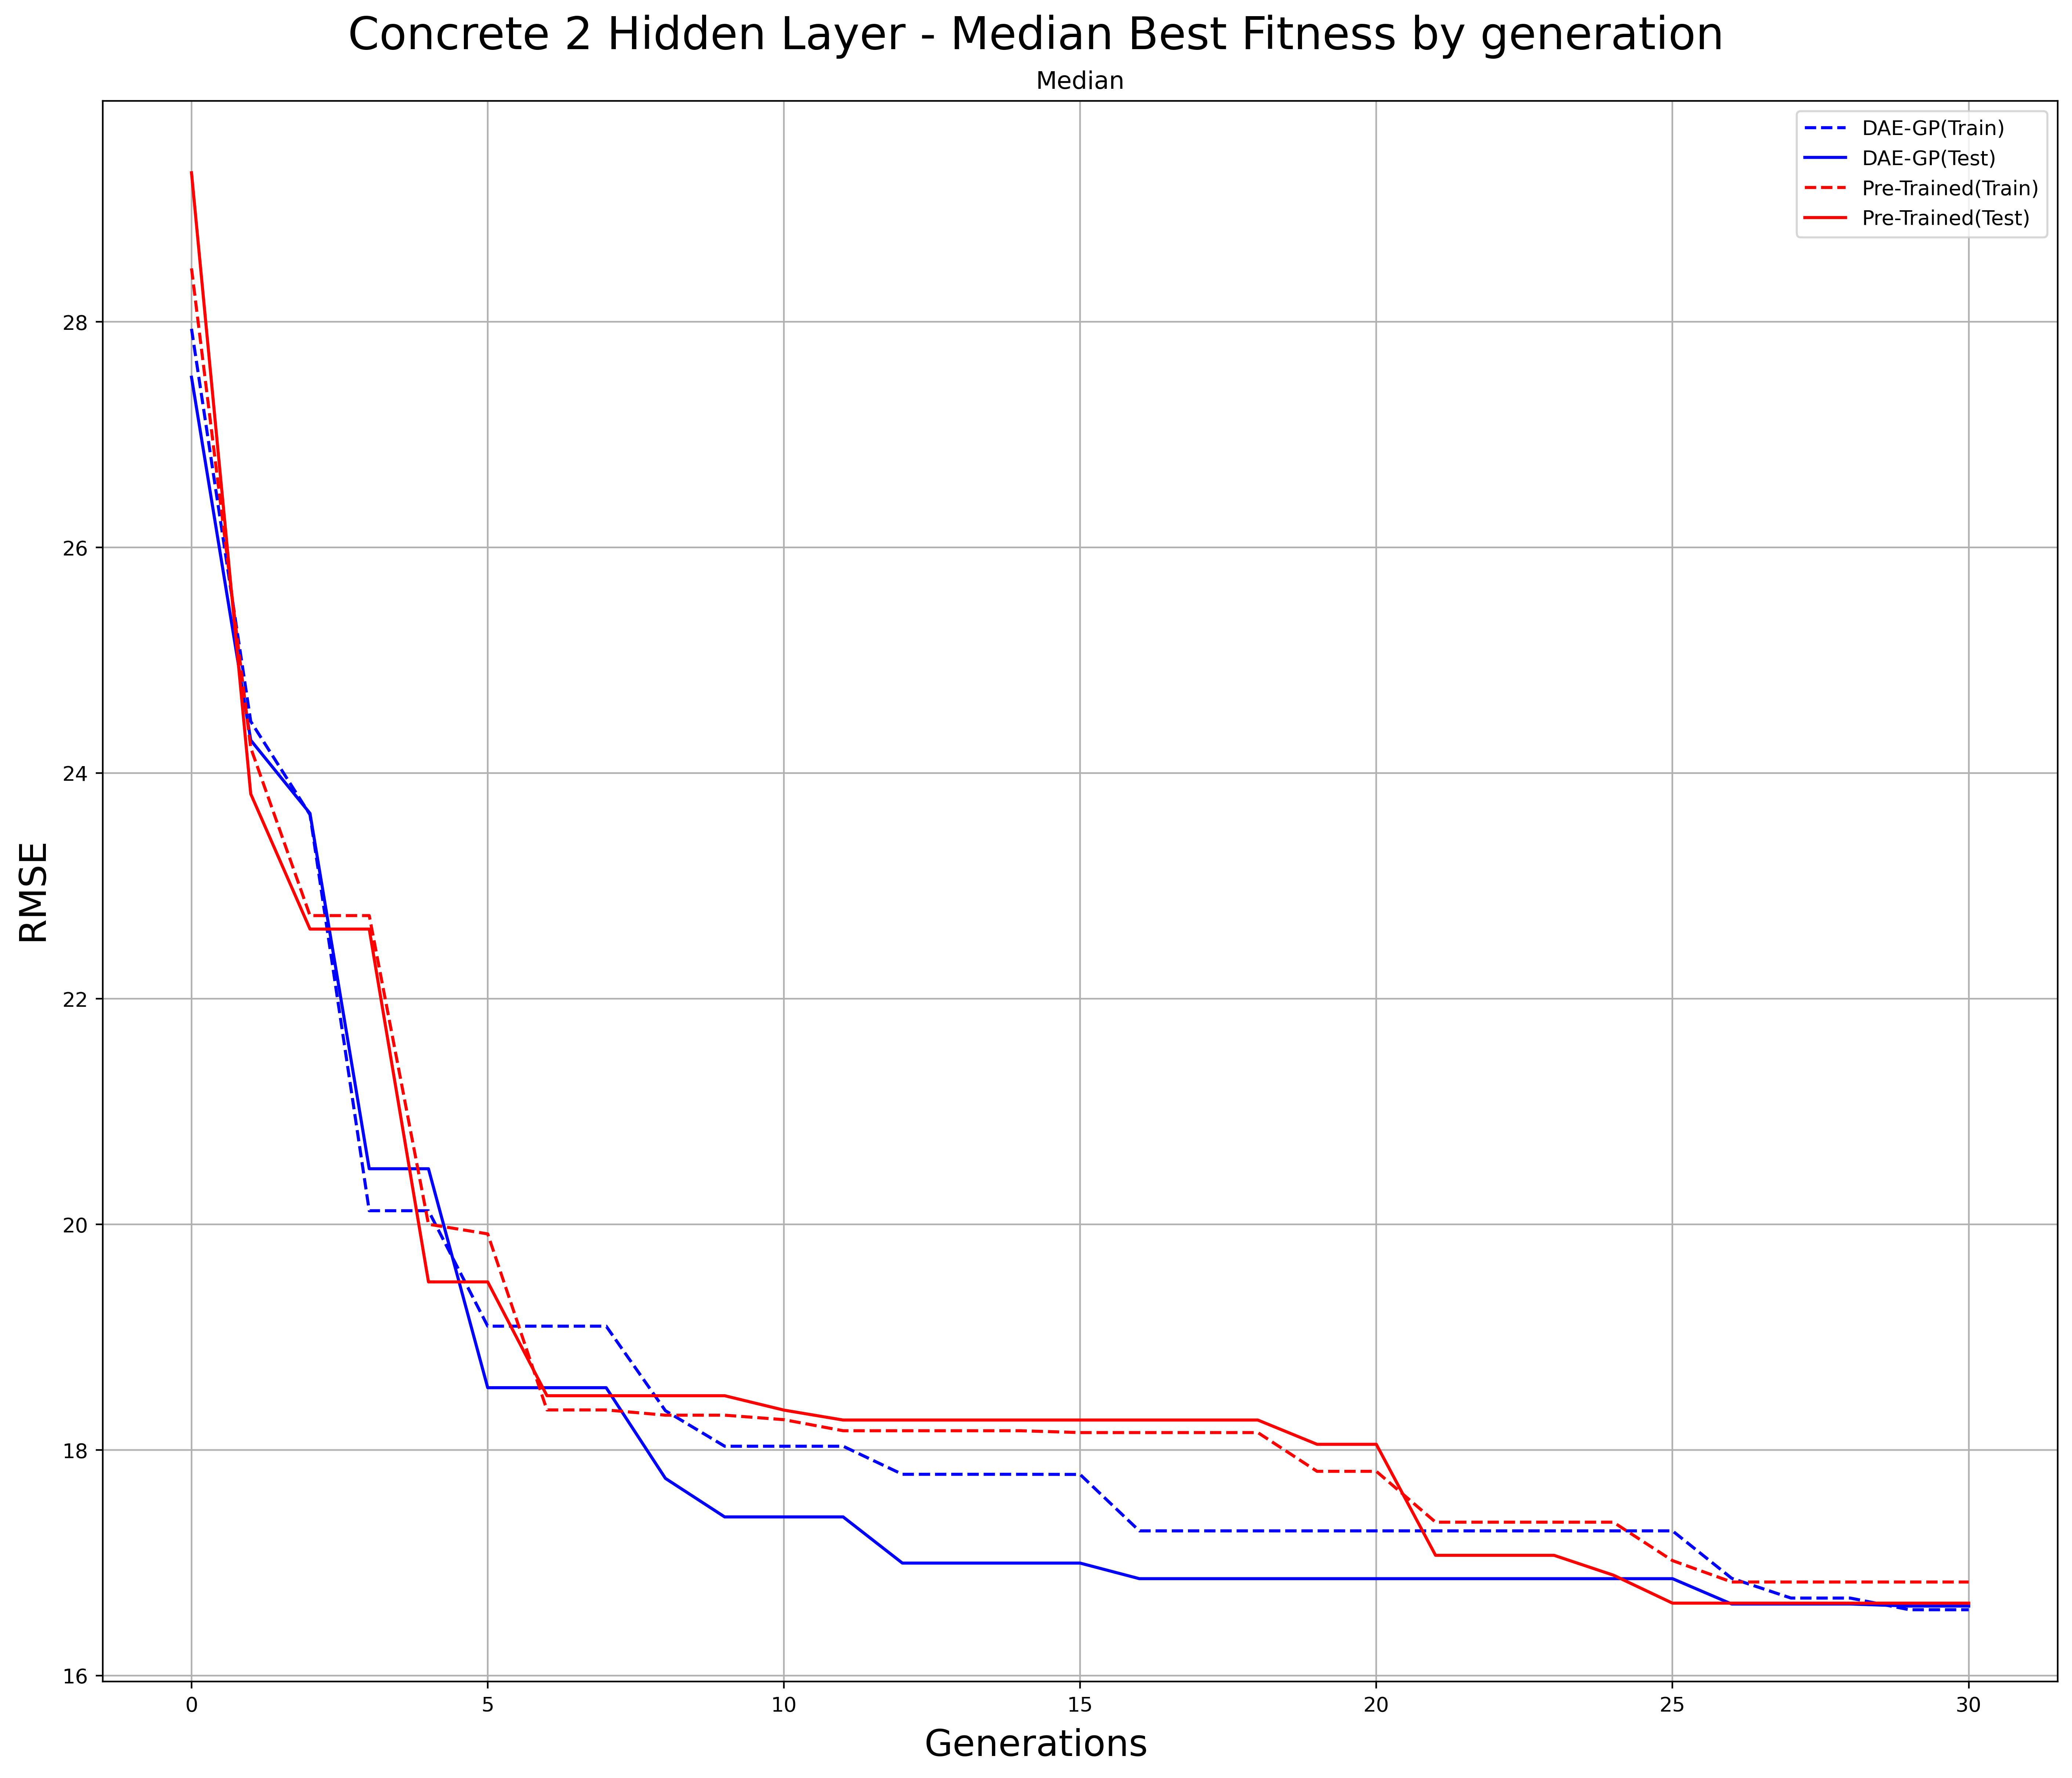

In [14]:
fig, ax = plt.subplots(ncols=1, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]



fig.suptitle(f"{BASE_TITLE} - Median Best Fitness by generation", fontsize=BIG)
fig.supxlabel("Generations", fontsize=MID)
fig.supylabel("RMSE", fontsize=MID)


ax.set_title("Median")
ax.plot(gens, reg_fits_med, color=C_REG, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Train)")
ax.plot(gens, reg_fits_test_med, color=C_REG, marker=M_TEST, label="DAE-GP(Test)")
ax.plot(gens, pt_fits_med, color=C_PT, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="Pre-Trained(Train)")
ax.plot(gens, pt_fits_test_med, color=C_PT, marker=M_TEST, label="Pre-Trained(Test)")
ax.grid()

ax.legend()


fig.savefig(f"{IMG_PATH}/median_fitness_byGens.png")

{'problem': 'Concrete', 'hiddenLayer': 2, 'DAE-GP': [[0, 149, 176, 162, 123, 153, 278, 158, 172, 111, 290, 282, 181, 204, 327, 424, 162, 122, 140, 124, 153, 241, 113, 125, 100, 189, 238, 263, 159, 181, 105], [0, 256, 120, 133, 147, 128, 139, 126, 136, 163, 136, 232, 160, 154, 128, 161, 125, 103, 187, 320, 220, 159, 182, 187, 120, 225, 149, 305, 133, 295, 187], [0, 295, 265, 173, 326, 100, 98, 133, 161, 95, 119, 183, 268, 206, 270, 150, 90, 106, 139, 168, 146, 217, 127, 145, 326, 129, 166, 273, 155, 155, 115], [0, 127, 342, 146, 93, 156, 268, 243, 217, 125, 247, 148, 94, 91, 128, 158, 187, 237, 154, 192, 304, 117, 165, 218, 110, 83, 252, 280, 151, 110, 140], [0, 257, 144, 119, 159, 161, 183, 187, 156, 244, 105, 137, 132, 147, 180, 152, 205, 134, 176, 108, 88, 139, 222, 234, 197, 145, 165, 215, 136, 151, 180], [0, 282, 157, 239, 155, 133, 132, 106, 124, 232, 265, 203, 201, 168, 114, 124, 145, 223, 135, 305, 233, 142, 149, 124, 258, 208, 274, 138, 133, 276, 116], [0, 295, 117, 137, 148, 1

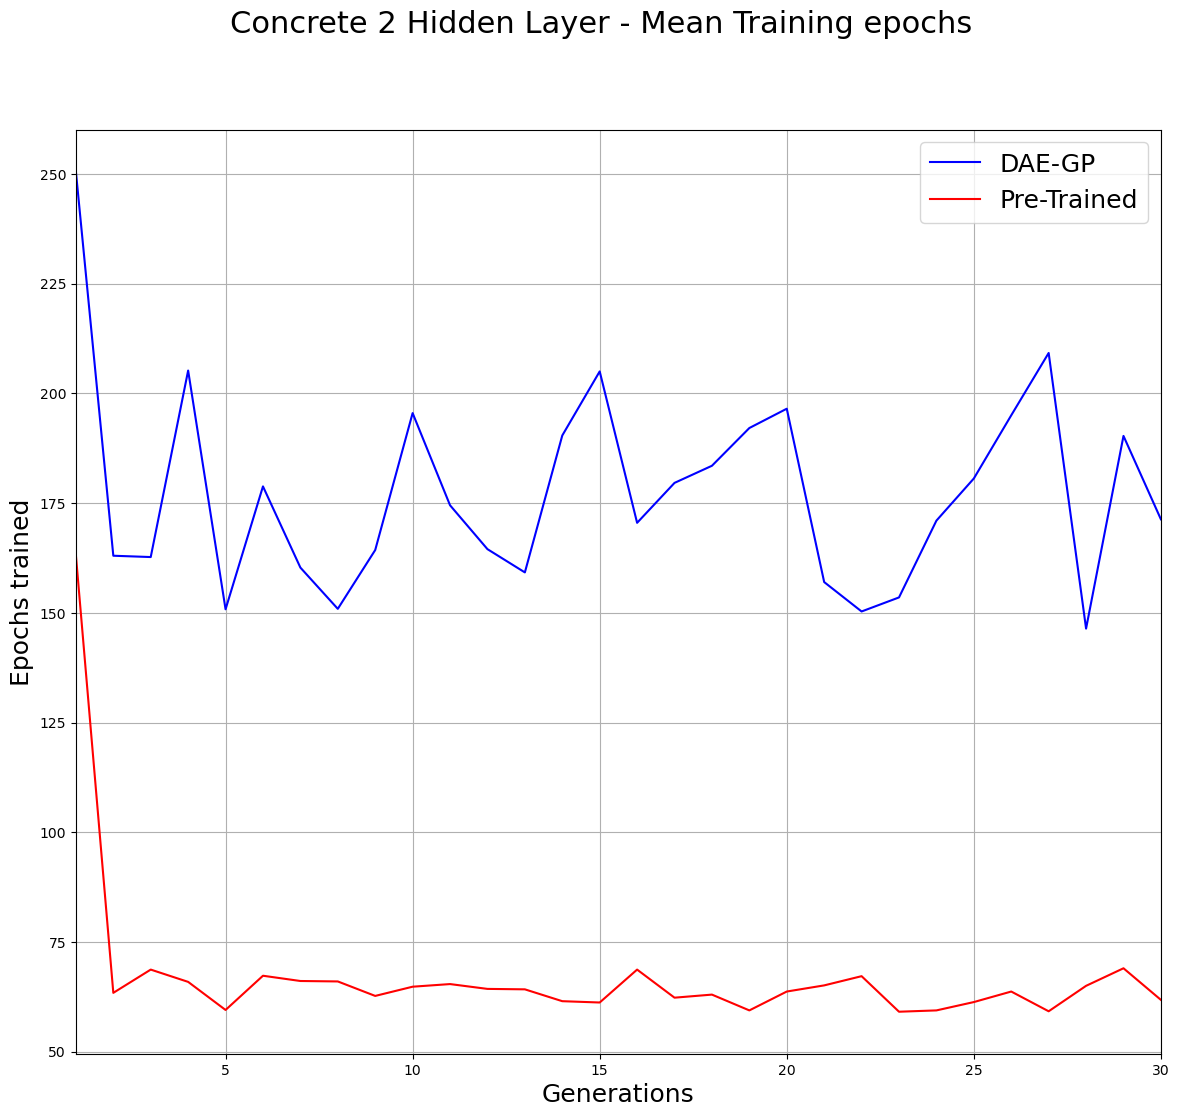

In [27]:
# mean epochs trained


reg_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(reg_results, "epochs_trained", 30)))
)
pt_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(pt_results, "epochs_trained", 30)))
)

gens = np.arange(1,31)

reg_epochs_mean = reg_epochs.mean(axis=0)
pt_epochs_mean = pt_epochs.mean(axis=0)

fig,ax = plt.subplots()
fig.set_size_inches(14,12)

fig.suptitle(f"{BASE_TITLE} - Mean Training epochs", fontsize=BIG)

#ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=1, right=30)
    
ax.plot(gens, reg_epochs_mean[1:], color=C_REG, label="DAE-GP")
ax.plot(gens, pt_epochs_mean[1:], color=C_PT, label="Pre-Trained")

ax.set_ylabel("Epochs trained", fontsize=MID)
ax.set_xlabel("Generations", fontsize=MID)


ax.grid()
ax.legend(fontsize=MID)

fig.savefig(f"{IMG_PATH}/mean_epochs_trained_perGen.png")

D = {
    "problem": "Concrete",
    "hiddenLayer": 2,
    "DAE-GP" : reg_epochs.tolist(),
    "Pre-Trained" : pt_epochs.tolist(),
}

writeData(DATAPATH, "mean_epochs_trained_perGen", D)


{'problem': 'Concrete', 'hiddenLayer': 2, 'DAE-GP': [[0, 149, 176, 162, 123, 153, 278, 158, 172, 111, 290, 282, 181, 204, 327, 424, 162, 122, 140, 124, 153, 241, 113, 125, 100, 189, 238, 263, 159, 181, 105], [0, 256, 120, 133, 147, 128, 139, 126, 136, 163, 136, 232, 160, 154, 128, 161, 125, 103, 187, 320, 220, 159, 182, 187, 120, 225, 149, 305, 133, 295, 187], [0, 295, 265, 173, 326, 100, 98, 133, 161, 95, 119, 183, 268, 206, 270, 150, 90, 106, 139, 168, 146, 217, 127, 145, 326, 129, 166, 273, 155, 155, 115], [0, 127, 342, 146, 93, 156, 268, 243, 217, 125, 247, 148, 94, 91, 128, 158, 187, 237, 154, 192, 304, 117, 165, 218, 110, 83, 252, 280, 151, 110, 140], [0, 257, 144, 119, 159, 161, 183, 187, 156, 244, 105, 137, 132, 147, 180, 152, 205, 134, 176, 108, 88, 139, 222, 234, 197, 145, 165, 215, 136, 151, 180], [0, 282, 157, 239, 155, 133, 132, 106, 124, 232, 265, 203, 201, 168, 114, 124, 145, 223, 135, 305, 233, 142, 149, 124, 258, 208, 274, 138, 133, 276, 116], [0, 295, 117, 137, 148, 1

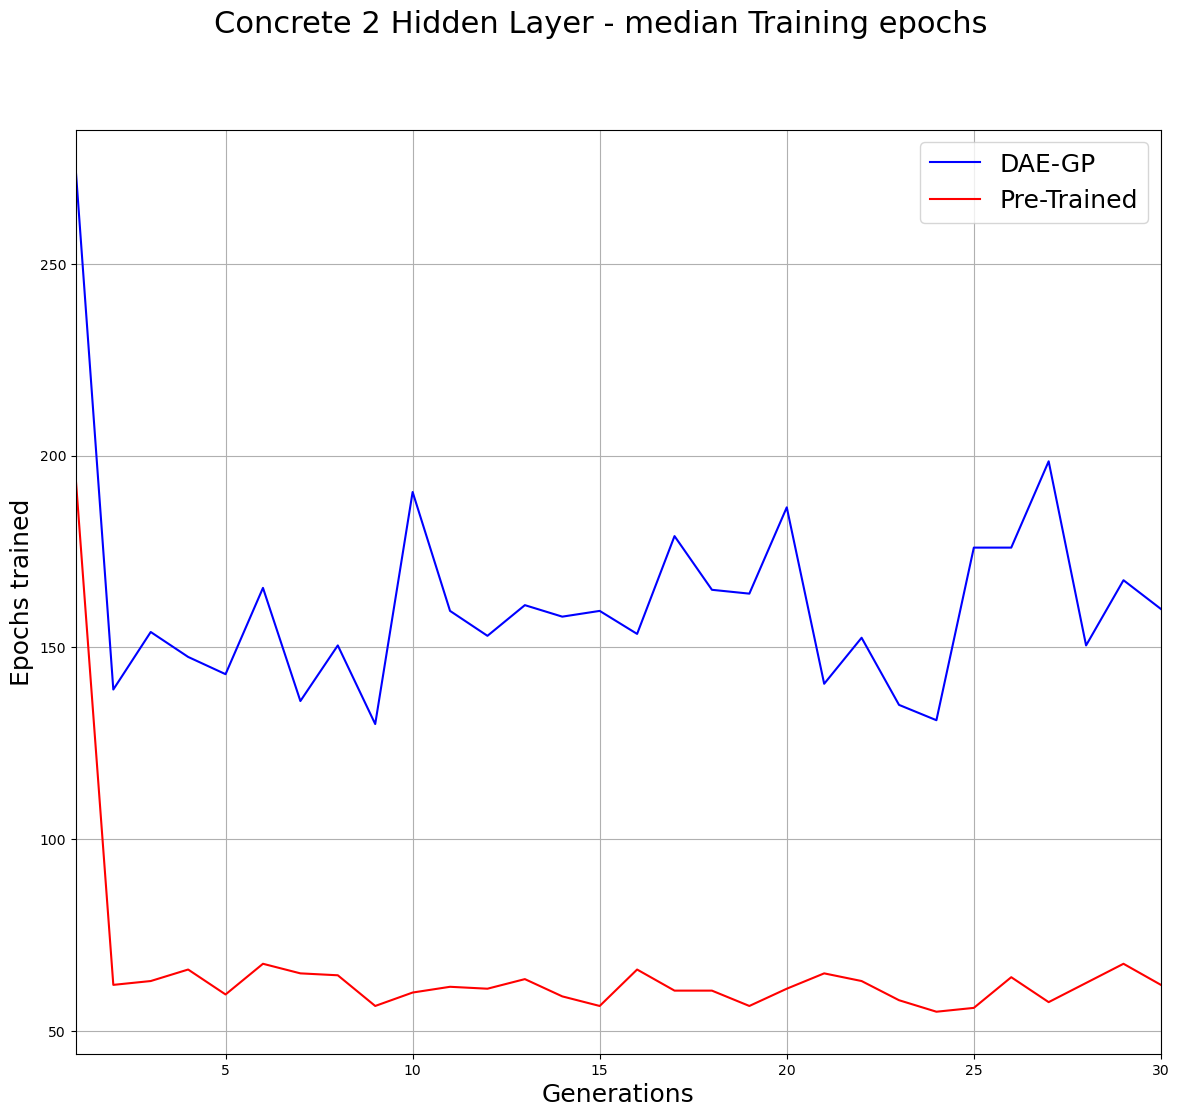

In [28]:
# median epochs trained


reg_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(reg_results, "epochs_trained", 30)))
)
pt_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(pt_results, "epochs_trained", 30)))
)

gens = np.arange(1,31)

reg_epochs_median = np.median(reg_epochs, axis=0)
pt_epochs_median = np.median(pt_epochs, axis=0)

fig,ax = plt.subplots()
fig.set_size_inches(14,12)

fig.suptitle(f"{BASE_TITLE} - median Training epochs", fontsize=BIG)

#ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=1, right=30)
    
ax.plot(gens, reg_epochs_median[1:], color=C_REG, label="DAE-GP")
ax.plot(gens, pt_epochs_median[1:], color=C_PT, label="Pre-Trained")

ax.set_ylabel("Epochs trained", fontsize=MID)
ax.set_xlabel("Generations", fontsize=MID)


ax.grid()
ax.legend(fontsize=MID)

fig.savefig(f"{IMG_PATH}/median_epochs_trained_perGen.png")

D = {
    "problem": "Concrete",
    "hiddenLayer": 2,
    "DAE-GP" : reg_epochs.tolist(),
    "Pre-Trained" : pt_epochs.tolist(),
}

writeData(DATAPATH, "median_epochs_trained_perGen", D)

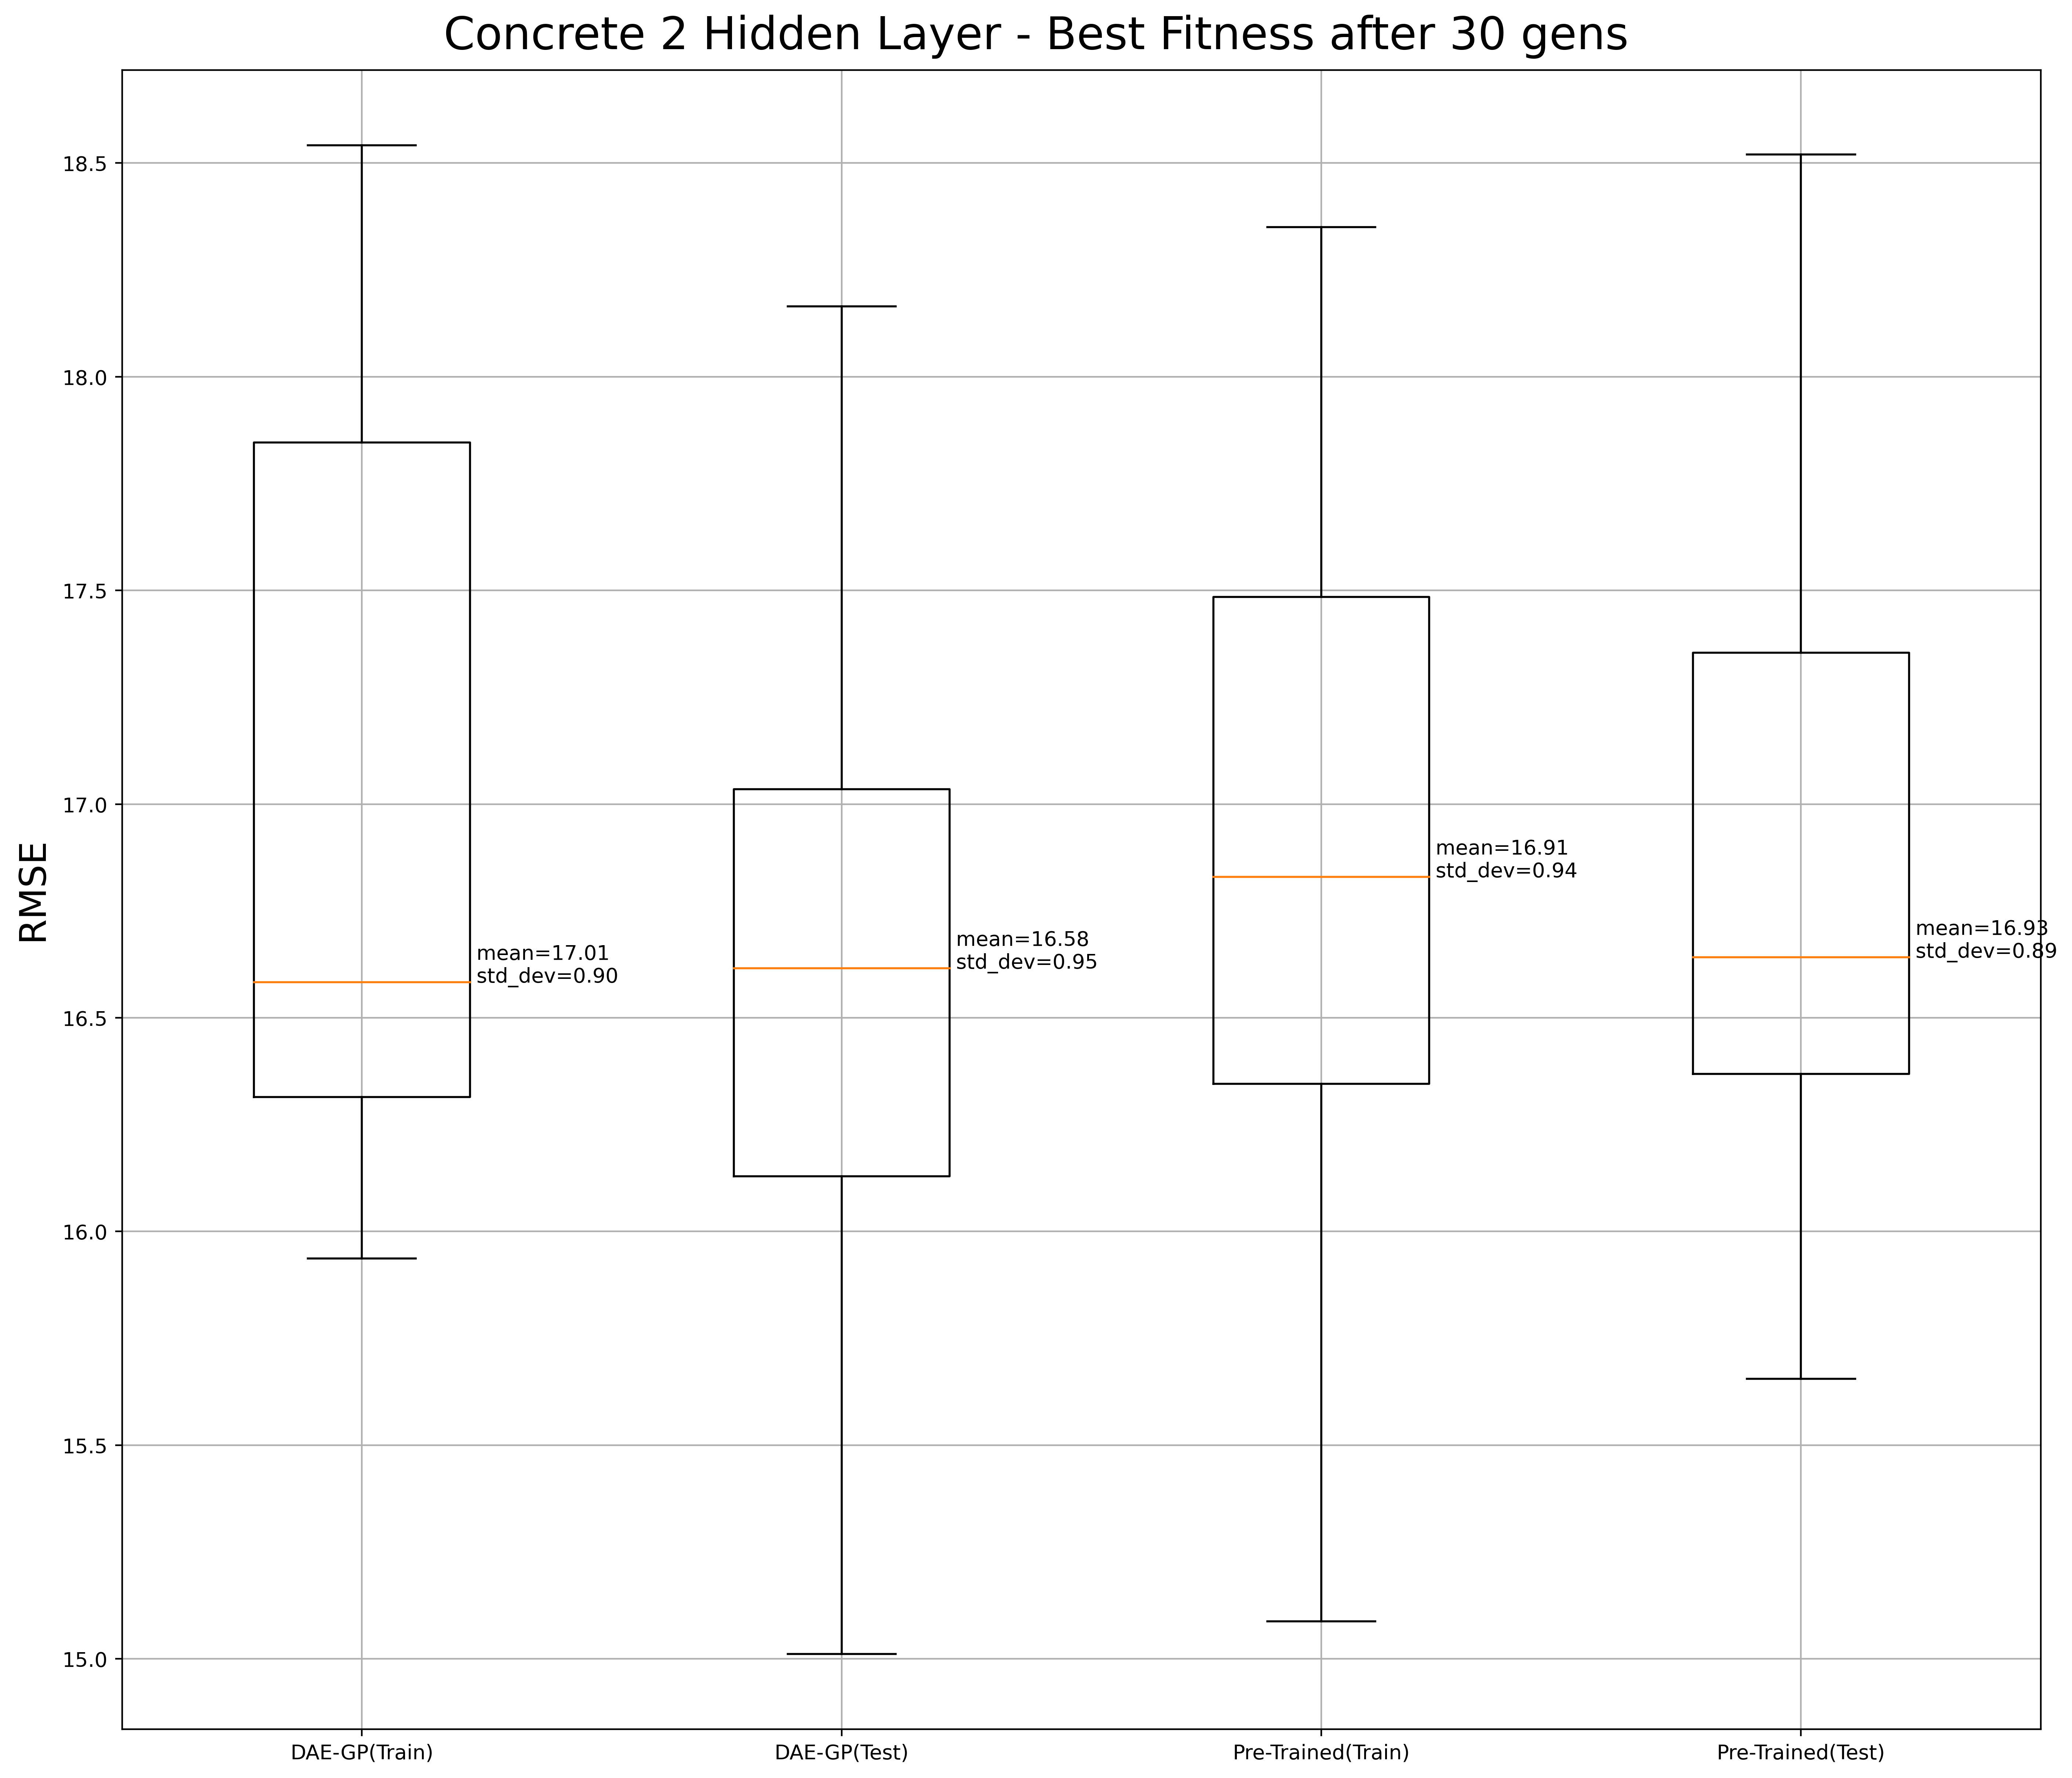

In [16]:
# uncomment if experiments are done!


def last_fits(arr):
    ret = []
    for run in arr:
        ret.append(run[-1])
    return ret

fig, ax = plt.subplots(layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)

LABELS = ["DAE-GP(Train)", "DAE-GP(Test)", "Pre-Trained(Train)", "Pre-Trained(Test)"]

X = [
    last_fits(reg_fits),
    last_fits(reg_fits_test),
    last_fits(pt_fits),
    last_fits(pt_fits_test)
]


std_dev = np.std(X, 1)
means = np.mean(X,1)

fig.suptitle(f"{BASE_TITLE} - Best Fitness after 30 gens", fontsize=BIG)
fig.supylabel("RMSE", fontsize=MID)

bp_dict = ax.boxplot(
    x=X,
    labels=LABELS,
    #patch_artist=True,  # fill with color
    #notch=True,  # notch shape
)

for i, line in enumerate(bp_dict['medians']):
    x, y = line.get_xydata()[1]
    text = ' mean={:.2f}\n std_dev={:.2f}'.format(means[i], std_dev[i])
    ax.annotate(text, xy=(x, y))


ax.grid()
fig.savefig(f"{IMG_PATH}/final_fit_boxplot.png")

In [17]:
D = {
    "problem": "Concrete",
    "hiddenLayer": 2,
    "DAE-GP (train)" : last_fits(reg_fits),
    "DAE-GP (test)" : last_fits(reg_fits_test),
    "Pre-Trained (train)" : last_fits(pt_fits),
    "Pre-Trained (test)" : last_fits(pt_fits_test)
}

writeData(DATAPATH, "best_final_fitness", D)

{'problem': 'Concrete', 'hiddenLayer': 2, 'DAE-GP (train)': [17.909110595730237, 16.026683309819703, 16.60798009978881, 16.463053934624917, 18.54125974636095, 17.656385148292795, 16.26475908691364, 18.087363216393413, 15.936452926808975, 16.55860836698569], 'DAE-GP (test)': [16.310706151041746, 16.647849670670123, 16.06799531912751, 16.930914150765236, 18.16450260034316, 16.583951307540485, 17.069713911185175, 17.83664209313905, 15.221463241381745, 15.011608632220703], 'Pre-Trained (train)': [15.087969978040531, 18.35022033652901, 16.288501078326416, 17.527977109563956, 16.51729964153166, 16.682988447100918, 17.354876855789314, 18.186393630530233, 16.11378903450346, 16.975401655313586], 'Pre-Trained (test)': [15.654929897546248, 18.357474807302214, 16.130181485565547, 16.719611117556834, 16.319926638396456, 16.514119104624093, 17.070702080305985, 18.51978818494714, 16.563552744565428, 17.448104734754185]}


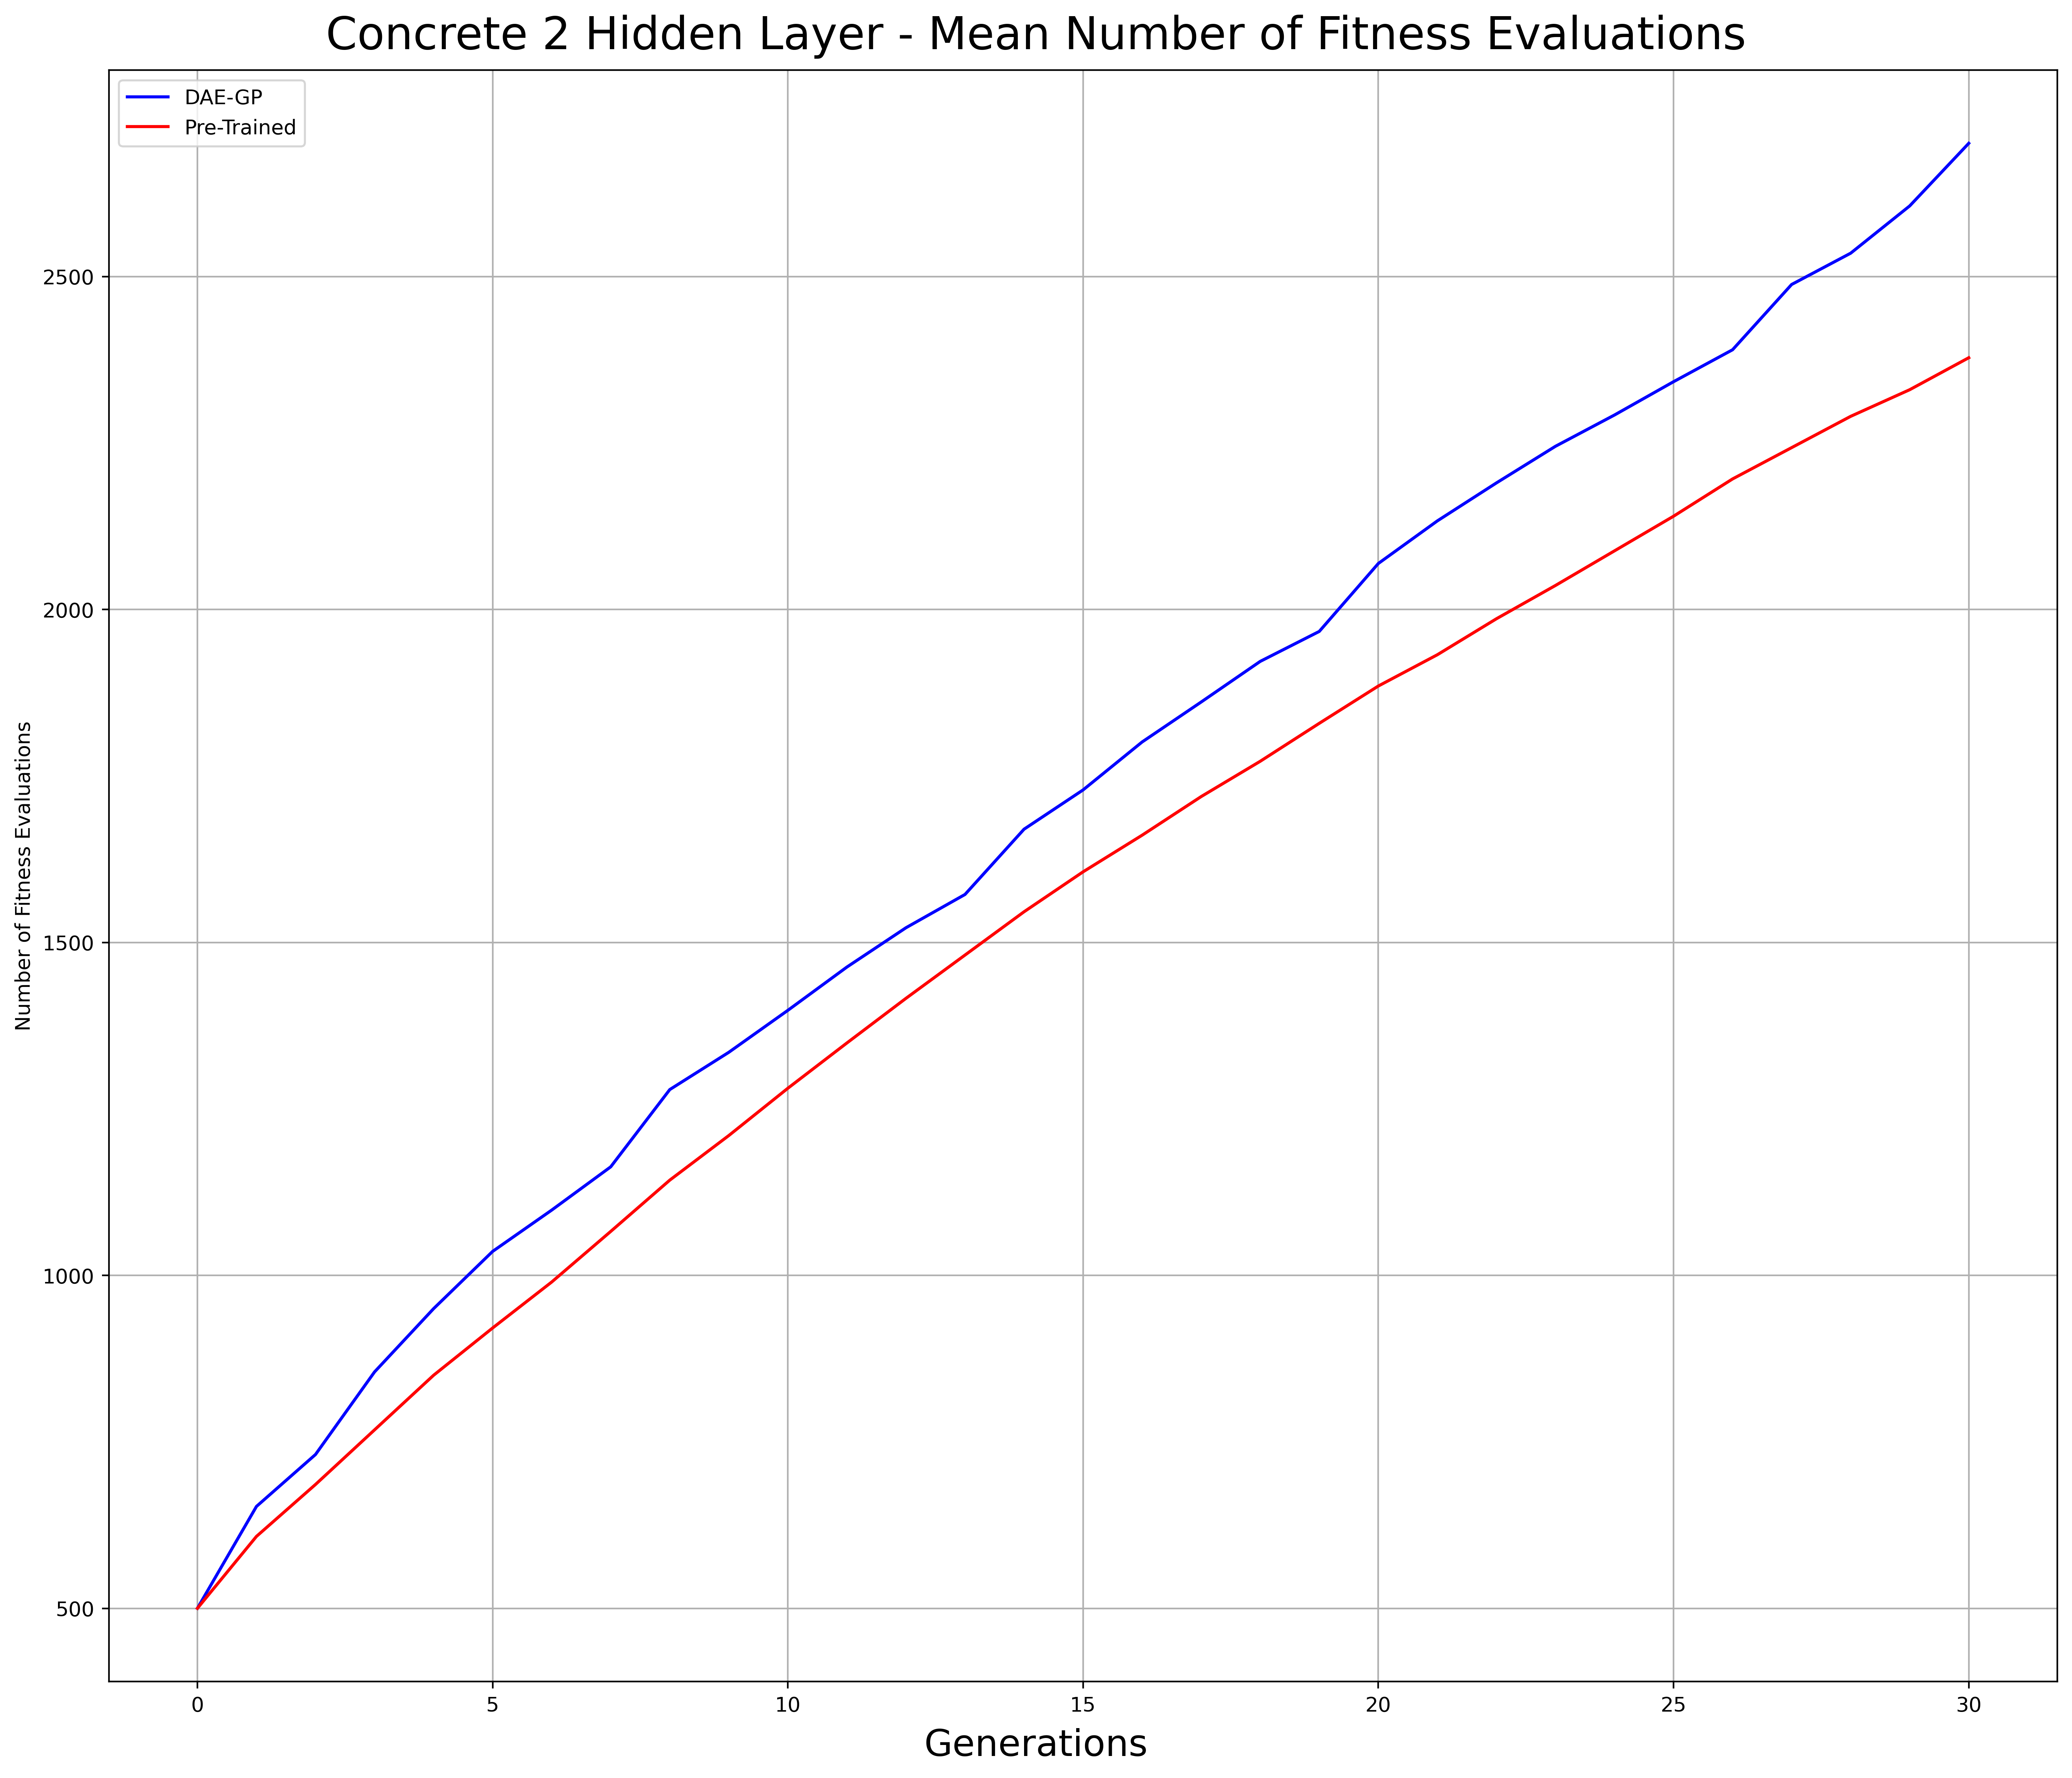

In [18]:
# number of evals per generation


reg_nevals = get_vals(reg_results, "fitness_nevals", 30)
pt_nevals = get_vals(pt_results, "fitness_nevals", 30)


reg_nevals_mean = get_means(reg_nevals)
pt_nevals_mean = get_means(pt_nevals)



fig, ax = plt.subplots(layout="constrained", sharex=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]


fig.suptitle(f"{BASE_TITLE} - Mean Number of Fitness Evaluations", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

ax.set_ylabel("Number of Fitness Evaluations")
ax.plot(gens, reg_nevals_mean, color=C_REG, label="DAE-GP")
ax.plot(gens, pt_nevals_mean, color=C_PT, label="Pre-Trained")

ax.grid()

ax.legend()


fig.savefig(f"{IMG_PATH}/mean_nevals_byGens.png")


In [19]:
# plot total runtime

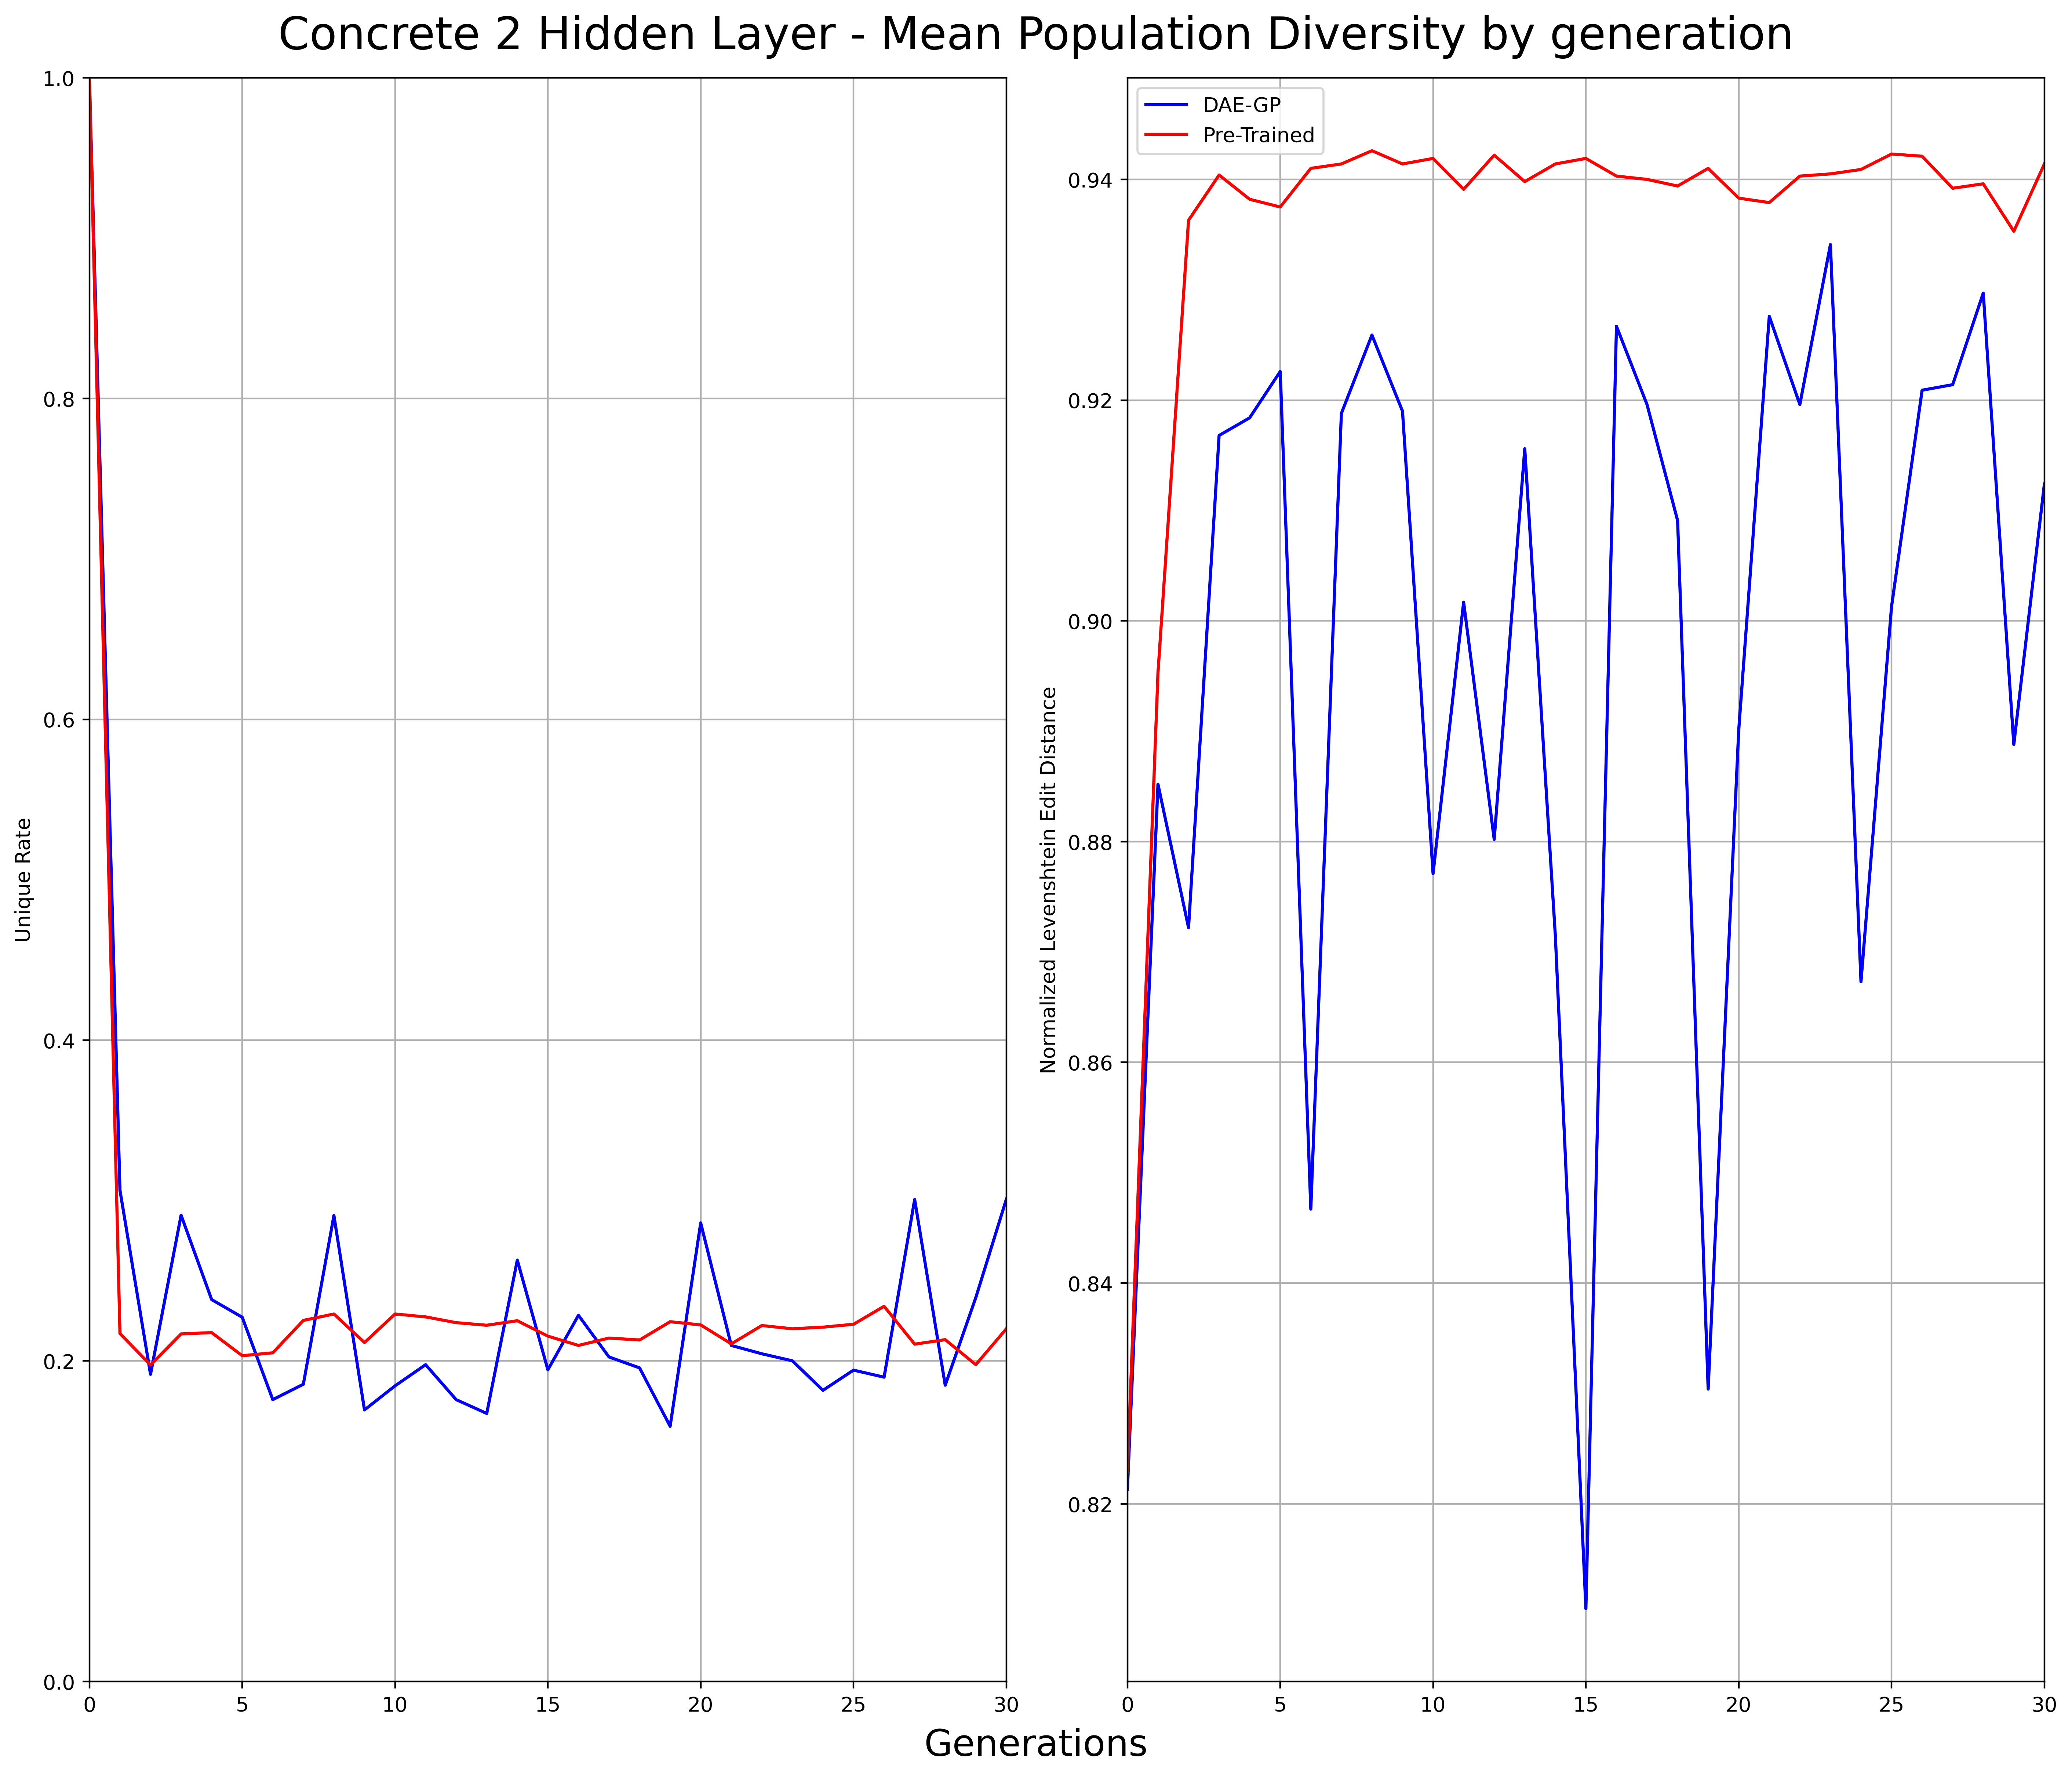

In [20]:
#  unique rate and lev diversity per generation

reg_levdiv = get_vals(reg_results, "norm_lev_div", 30)
pt_levdiv = get_vals(pt_results, "norm_lev_div", 30)

reg_levdiv_mean = get_means(reg_levdiv)
pt_levdiv_mean = get_means(pt_levdiv)

reg_ur = get_vals(reg_results, "unique_rate", 30)
pt_ur = get_vals(pt_results, "unique_rate", 30)

reg_ur_mean = get_means(reg_ur)
pt_ur_mean = get_means(pt_ur)



fig, (axl, axr) = plt.subplots(ncols=2, layout="constrained", sharex=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

axl.set_ylim(bottom=0, top=1)
axl.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - Mean Population Diversity by generation", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axr.set_ylabel("Normalized Levenshtein Edit Distance")
axr.plot(gens, reg_levdiv_mean, color=C_REG, label="DAE-GP")
axr.plot(gens, pt_levdiv_mean, color=C_PT, label="Pre-Trained")


axl.set_ylabel("Unique Rate")
axl.plot(gens, reg_ur_mean, color=C_REG, label="DAE-GP")
axl.plot(gens, pt_ur_mean, color=C_PT, label="Pre-Trained")

axl.grid()
axr.grid()

axr.legend()


fig.savefig(f"{IMG_PATH}/mean_popDiversity_byGens.png")


{'problem': 'Concrete', 'hiddenLayer': 2, 'DAE-GP': [[0.821, 0.939, 0.94, 0.938, 0.93, 0.928, 0.688, 0.914, 0.926, 0.939, 0.911, 0.778, 0.738, 0.91, 0.799, 0.898, 0.935, 0.95, 0.948, 0.946, 0.921, 0.945, 0.938, 0.937, 0.936, 0.889, 0.911, 0.912, 0.914, 0.939, 0.943], [0.817, 0.883, 0.93, 0.94, 0.94, 0.926, 0.905, 0.912, 0.949, 0.937, 0.939, 0.924, 0.911, 0.922, 0.926, 0.931, 0.944, 0.929, 0.939, 0.494, 0.937, 0.932, 0.926, 0.935, 0.931, 0.91, 0.936, 0.873, 0.932, 0.924, 0.896], [0.821, 0.828, 0.655, 0.934, 0.918, 0.939, 0.939, 0.948, 0.938, 0.938, 0.915, 0.889, 0.874, 0.863, 0.929, 0.945, 0.939, 0.912, 0.938, 0.934, 0.933, 0.926, 0.942, 0.94, 0.481, 0.935, 0.94, 0.895, 0.925, 0.92, 0.938], [0.821, 0.941, 0.721, 0.939, 0.937, 0.858, 0.567, 0.897, 0.92, 0.889, 0.943, 0.928, 0.926, 0.93, 0.943, 0.925, 0.944, 0.859, 0.879, 0.915, 0.862, 0.922, 0.902, 0.913, 0.915, 0.903, 0.91, 0.924, 0.943, 0.941, 0.945], [0.816, 0.859, 0.931, 0.936, 0.942, 0.942, 0.911, 0.875, 0.911, 0.941, 0.909, 0.925, 

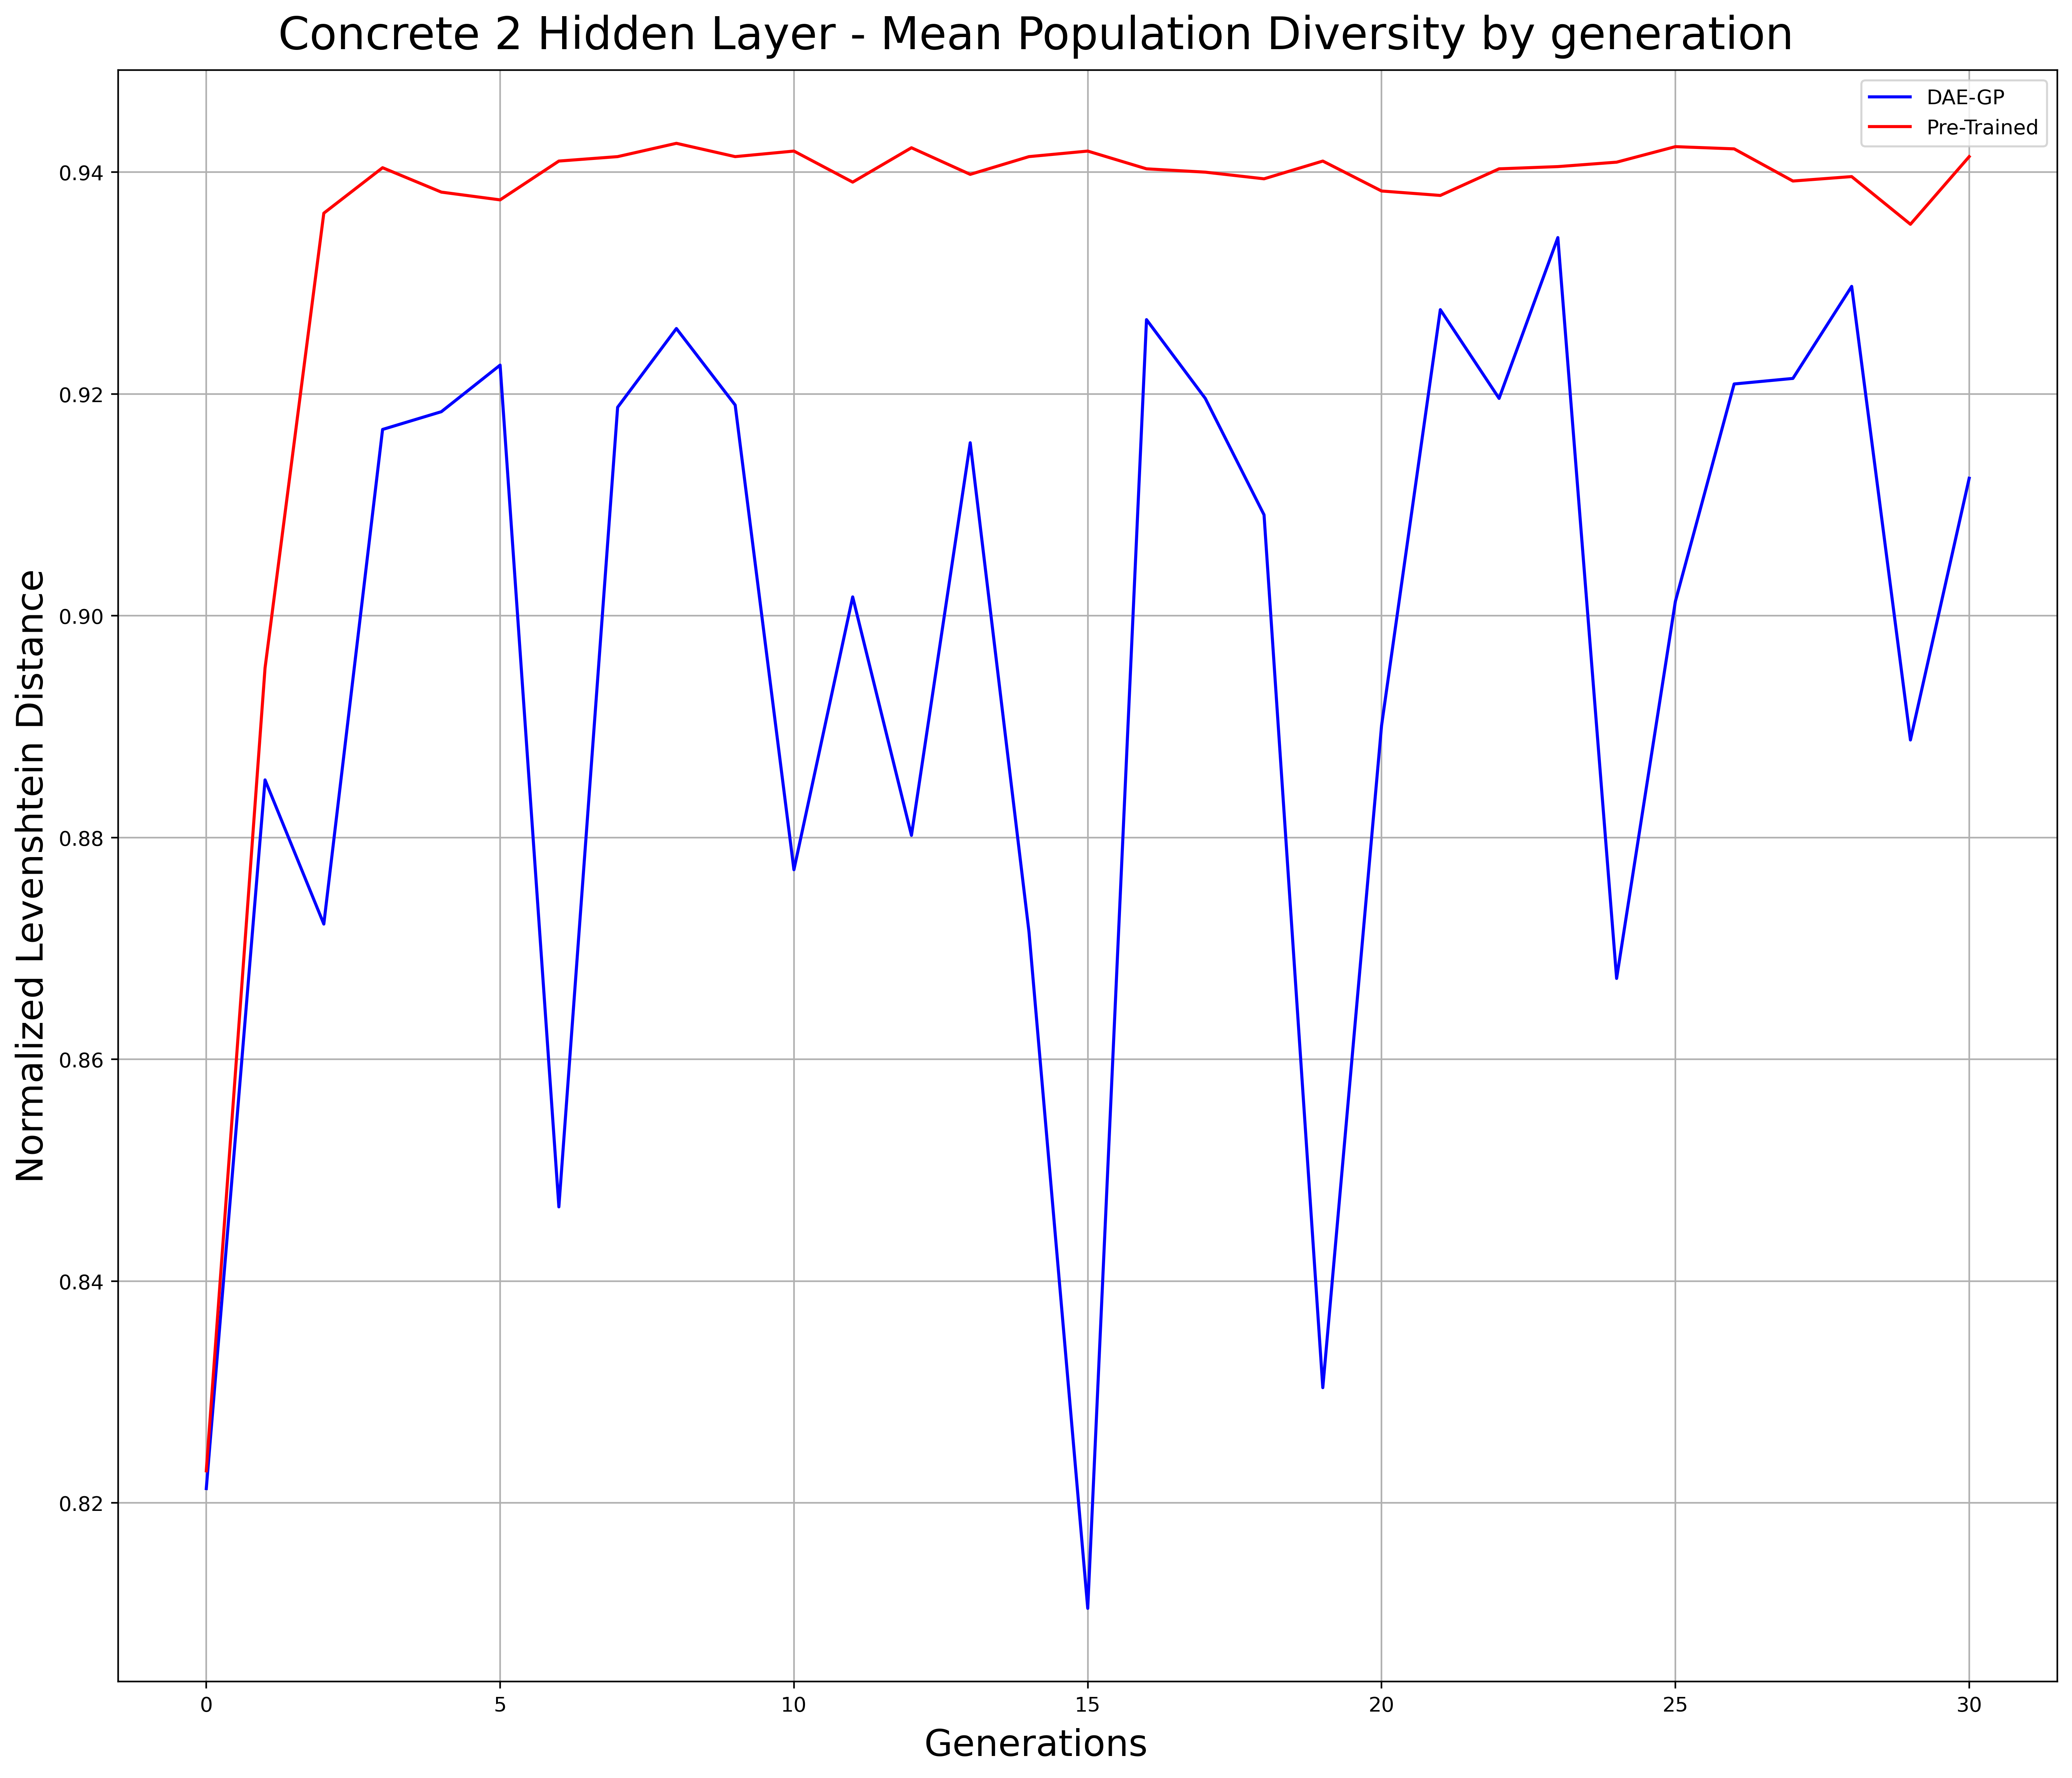

In [29]:
#  mean lev diversity per generation

reg_levdiv = get_vals(reg_results, "norm_lev_div", 30)
pt_levdiv = get_vals(pt_results, "norm_lev_div", 30)

reg_levdiv_mean = get_means(reg_levdiv)
pt_levdiv_mean = get_means(pt_levdiv)




fig, (axr) = plt.subplots(ncols=1, layout="constrained", sharex=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

axl.set_ylim(bottom=0, top=1)
axl.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - Mean Population Diversity by generation", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axr.set_ylabel("Normalized Levenshtein Distance",  fontsize=MID)
axr.plot(gens, reg_levdiv_mean, color=C_REG, label="DAE-GP")
axr.plot(gens, pt_levdiv_mean, color=C_PT, label="Pre-Trained")


axl.grid()
axr.grid()

axr.legend()


fig.savefig(f"{IMG_PATH}/mean_popDiversity_byGens_levOnly.png")

D = {
    "problem": "Concrete",
    "hiddenLayer": 2,
    "DAE-GP": reg_levdiv,
    "Pre-Trained" : pt_levdiv
}

writeData(DATAPATH, "mean_lev_div_ovrGens", D)

{'problem': 'Concrete', 'hiddenLayer': 1, 'DAE-GP': [[0.821, 0.939, 0.94, 0.938, 0.93, 0.928, 0.688, 0.914, 0.926, 0.939, 0.911, 0.778, 0.738, 0.91, 0.799, 0.898, 0.935, 0.95, 0.948, 0.946, 0.921, 0.945, 0.938, 0.937, 0.936, 0.889, 0.911, 0.912, 0.914, 0.939, 0.943], [0.817, 0.883, 0.93, 0.94, 0.94, 0.926, 0.905, 0.912, 0.949, 0.937, 0.939, 0.924, 0.911, 0.922, 0.926, 0.931, 0.944, 0.929, 0.939, 0.494, 0.937, 0.932, 0.926, 0.935, 0.931, 0.91, 0.936, 0.873, 0.932, 0.924, 0.896], [0.821, 0.828, 0.655, 0.934, 0.918, 0.939, 0.939, 0.948, 0.938, 0.938, 0.915, 0.889, 0.874, 0.863, 0.929, 0.945, 0.939, 0.912, 0.938, 0.934, 0.933, 0.926, 0.942, 0.94, 0.481, 0.935, 0.94, 0.895, 0.925, 0.92, 0.938], [0.821, 0.941, 0.721, 0.939, 0.937, 0.858, 0.567, 0.897, 0.92, 0.889, 0.943, 0.928, 0.926, 0.93, 0.943, 0.925, 0.944, 0.859, 0.879, 0.915, 0.862, 0.922, 0.902, 0.913, 0.915, 0.903, 0.91, 0.924, 0.943, 0.941, 0.945], [0.816, 0.859, 0.931, 0.936, 0.942, 0.942, 0.911, 0.875, 0.911, 0.941, 0.909, 0.925, 

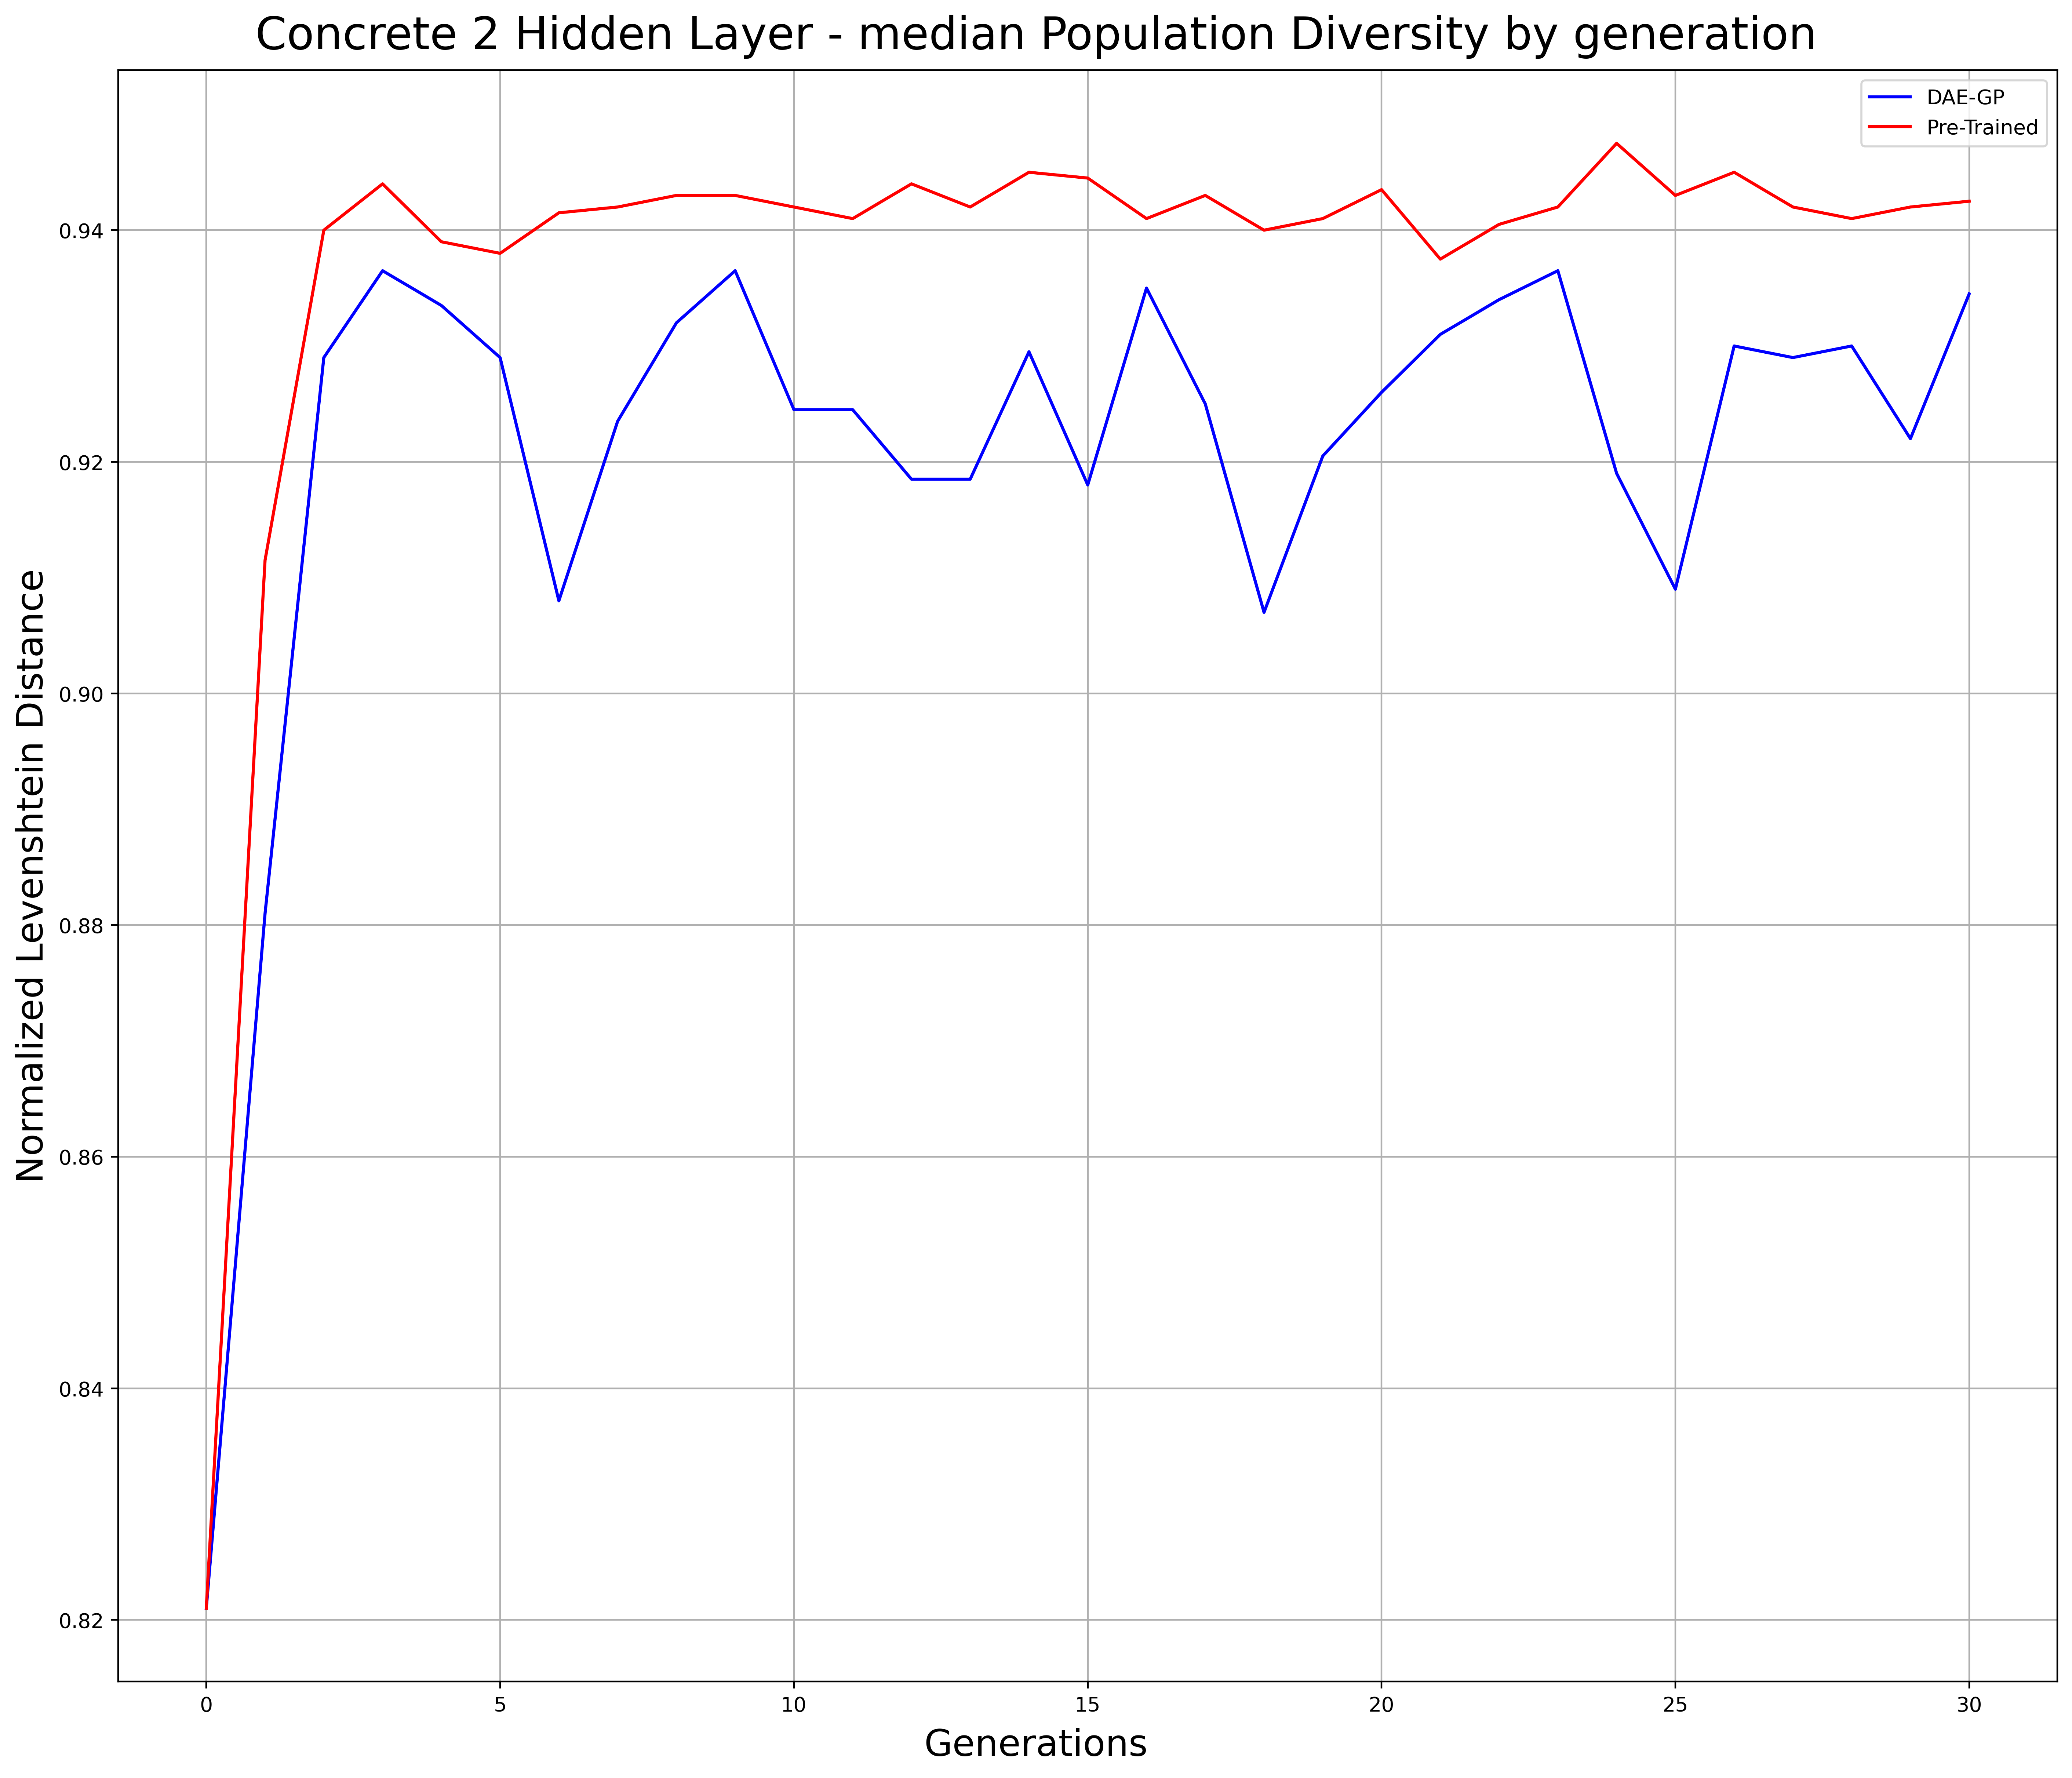

In [30]:
# median lev diversity 
reg_levdiv = get_vals(reg_results, "norm_lev_div", 30)

pt_levdiv = get_vals(pt_results, "norm_lev_div", 30)

reg_levdiv_median = get_medians(reg_levdiv)
pt_levdiv_median = get_medians(pt_levdiv)




fig, (axr) = plt.subplots(ncols=1, layout="constrained", sharex=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

axl.set_ylim(bottom=0, top=1)
axl.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - median Population Diversity by generation", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axr.set_ylabel("Normalized Levenshtein Distance",  fontsize=MID)
axr.plot(gens, reg_levdiv_median, color=C_REG, label="DAE-GP")
axr.plot(gens, pt_levdiv_median, color=C_PT, label="Pre-Trained")


axl.grid()
axr.grid()

axr.legend()


fig.savefig(f"{IMG_PATH}/median_popDiversity_byGens_levOnly.png")

D = {
    "problem": "Concrete",
    "hiddenLayer": 1,
    "DAE-GP": reg_levdiv,
    "Pre-Trained" : pt_levdiv
}

writeData(DATAPATH, "median_lev_div_ovrGens", D)

In [23]:
# plot sample time

{'problem': 'Concrete', 'hiddenLayer': 2, 'DAE-GP': [17.909110595730237, 16.026683309819703, 16.60798009978881, 16.463053934624917, 18.54125974636095, 17.656385148292795, 16.26475908691364, 18.087363216393413, 15.936452926808975, 16.55860836698569], 'Pre-Trained': [15.087969978040531, 18.35022033652901, 16.288501078326416, 17.527977109563956, 16.51729964153166, 16.682988447100918, 17.354876855789314, 18.186393630530233, 16.11378903450346, 16.975401655313586]}
{'problem': 'Concrete', 'hiddenLayer': 2, 'DAE-GP': [[22.88218386442024, 22.88218386442024, 22.88218386442024, 22.88218386442024, 22.88218386442024, 19.643896000974127, 19.643896000974127, 19.32276425265698, 19.32276425265698, 17.911625817258347, 17.911625817258347, 17.911625817258347, 17.911625817258347, 17.911625817258347, 17.911625817258347, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110595730237, 17.909110

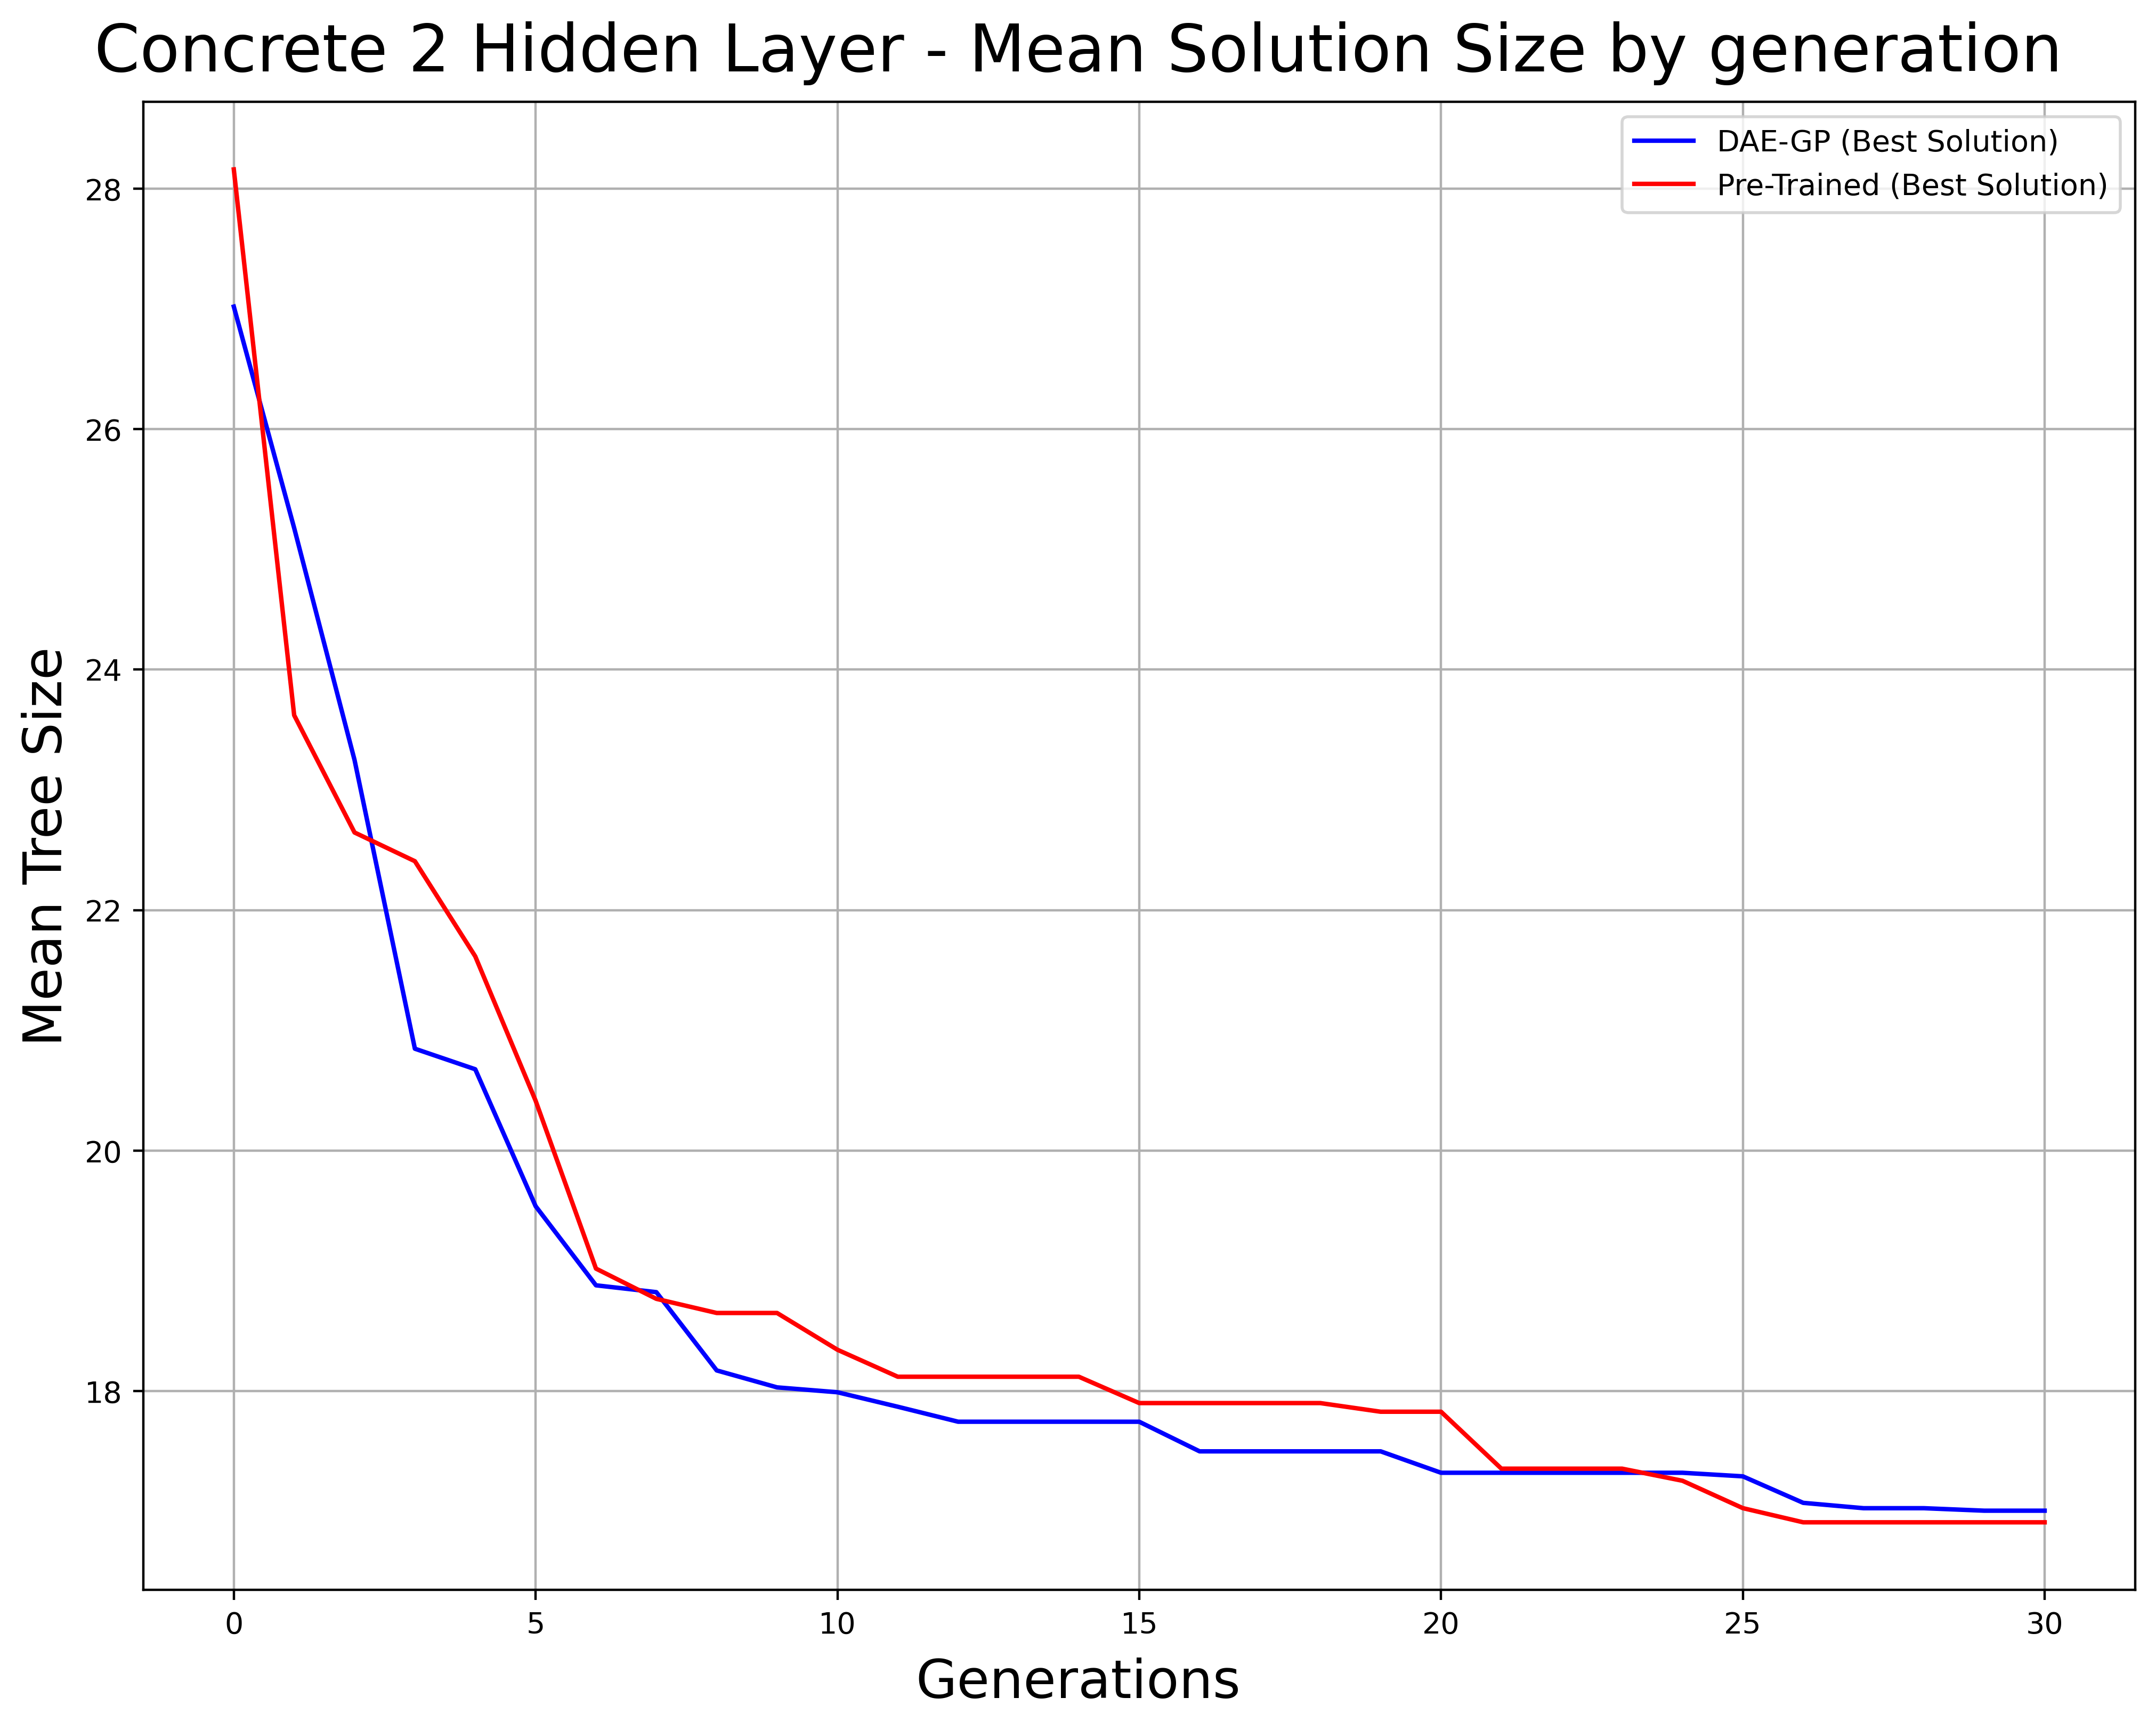

In [34]:
# plot mean size


reg_avgsize = get_vals(reg_results, "avg_size", 30)
pt_avgsize = get_vals(pt_results, "avg_size", 30)

reg_bestsize = get_vals(reg_results, "size_best_fitness", 30)
pt_bestsize = get_vals(pt_results, "size_best_fitness", 30)

reg_avgsize_mean = get_means(reg_avgsize)
pt_avgsize_mean = get_means(pt_avgsize)

reg_bestsize_mean = get_means(reg_bestsize)
pt_bestsize_mean = get_means(pt_bestsize)

# reg_avgsize_mean = get_means(reg_avgsize)
# pt_avgsize_mean = get_means(pt_avgsize)

# reg_bestsize_mean = get_means(reg_bestsize)
# pt_bestsize_mean = get_means(pt_bestsize)




fig, (axl) = plt.subplots(layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(10,8)
gens = [x for x in range(0, 31)]

# ax.set_ylim(bottom=0)
# ax.set_xlim(left=0)


fig.suptitle(f"{BASE_TITLE} - Mean Solution Size by generation", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axl.set_ylabel("Mean Tree Size", fontsize=MID)
axl.plot(gens, reg_bestsize_mean, color=C_REG, label="DAE-GP (Best Solution)")
# axl.plot(gens, reg_avgsize_mean, color=C_REG,linestyle=TRAIN_LINESTYLE, label="DAE-GP (Population average)")

axl.plot(gens, pt_bestsize_mean, color=C_PT, label="Pre-Trained (Best Solution)")
# axl.plot(gens, pt_avgsize_mean, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained (Population average)")



axl.grid()

axl.legend()


fig.savefig(f"{IMG_PATH}/mean_Size_byGens.png")

D = {
    "problem": "Concrete",
    "hiddenLayer": 2,
    "DAE-GP" : last_fits(reg_bestsize),
    "Pre-Trained" : last_fits(pt_bestsize)
}

writeData(DATAPATH, "mean_size_best_solution", D)

D = {
    "problem": "Concrete",
    "hiddenLayer": 2,
    "DAE-GP" : reg_bestsize,
    "Pre-Trained" : pt_bestsize
}

writeData(DATAPATH, "full_data_size_best_solution", D)


{'problem': 'Concrete', 'hiddenLayer': 2, 'DAE-GP': [17.909110595730237, 16.026683309819703, 16.60798009978881, 16.463053934624917, 18.54125974636095, 17.656385148292795, 16.26475908691364, 18.087363216393413, 15.936452926808975, 16.55860836698569], 'Pre-Trained': [15.087969978040531, 18.35022033652901, 16.288501078326416, 17.527977109563956, 16.51729964153166, 16.682988447100918, 17.354876855789314, 18.186393630530233, 16.11378903450346, 16.975401655313586]}


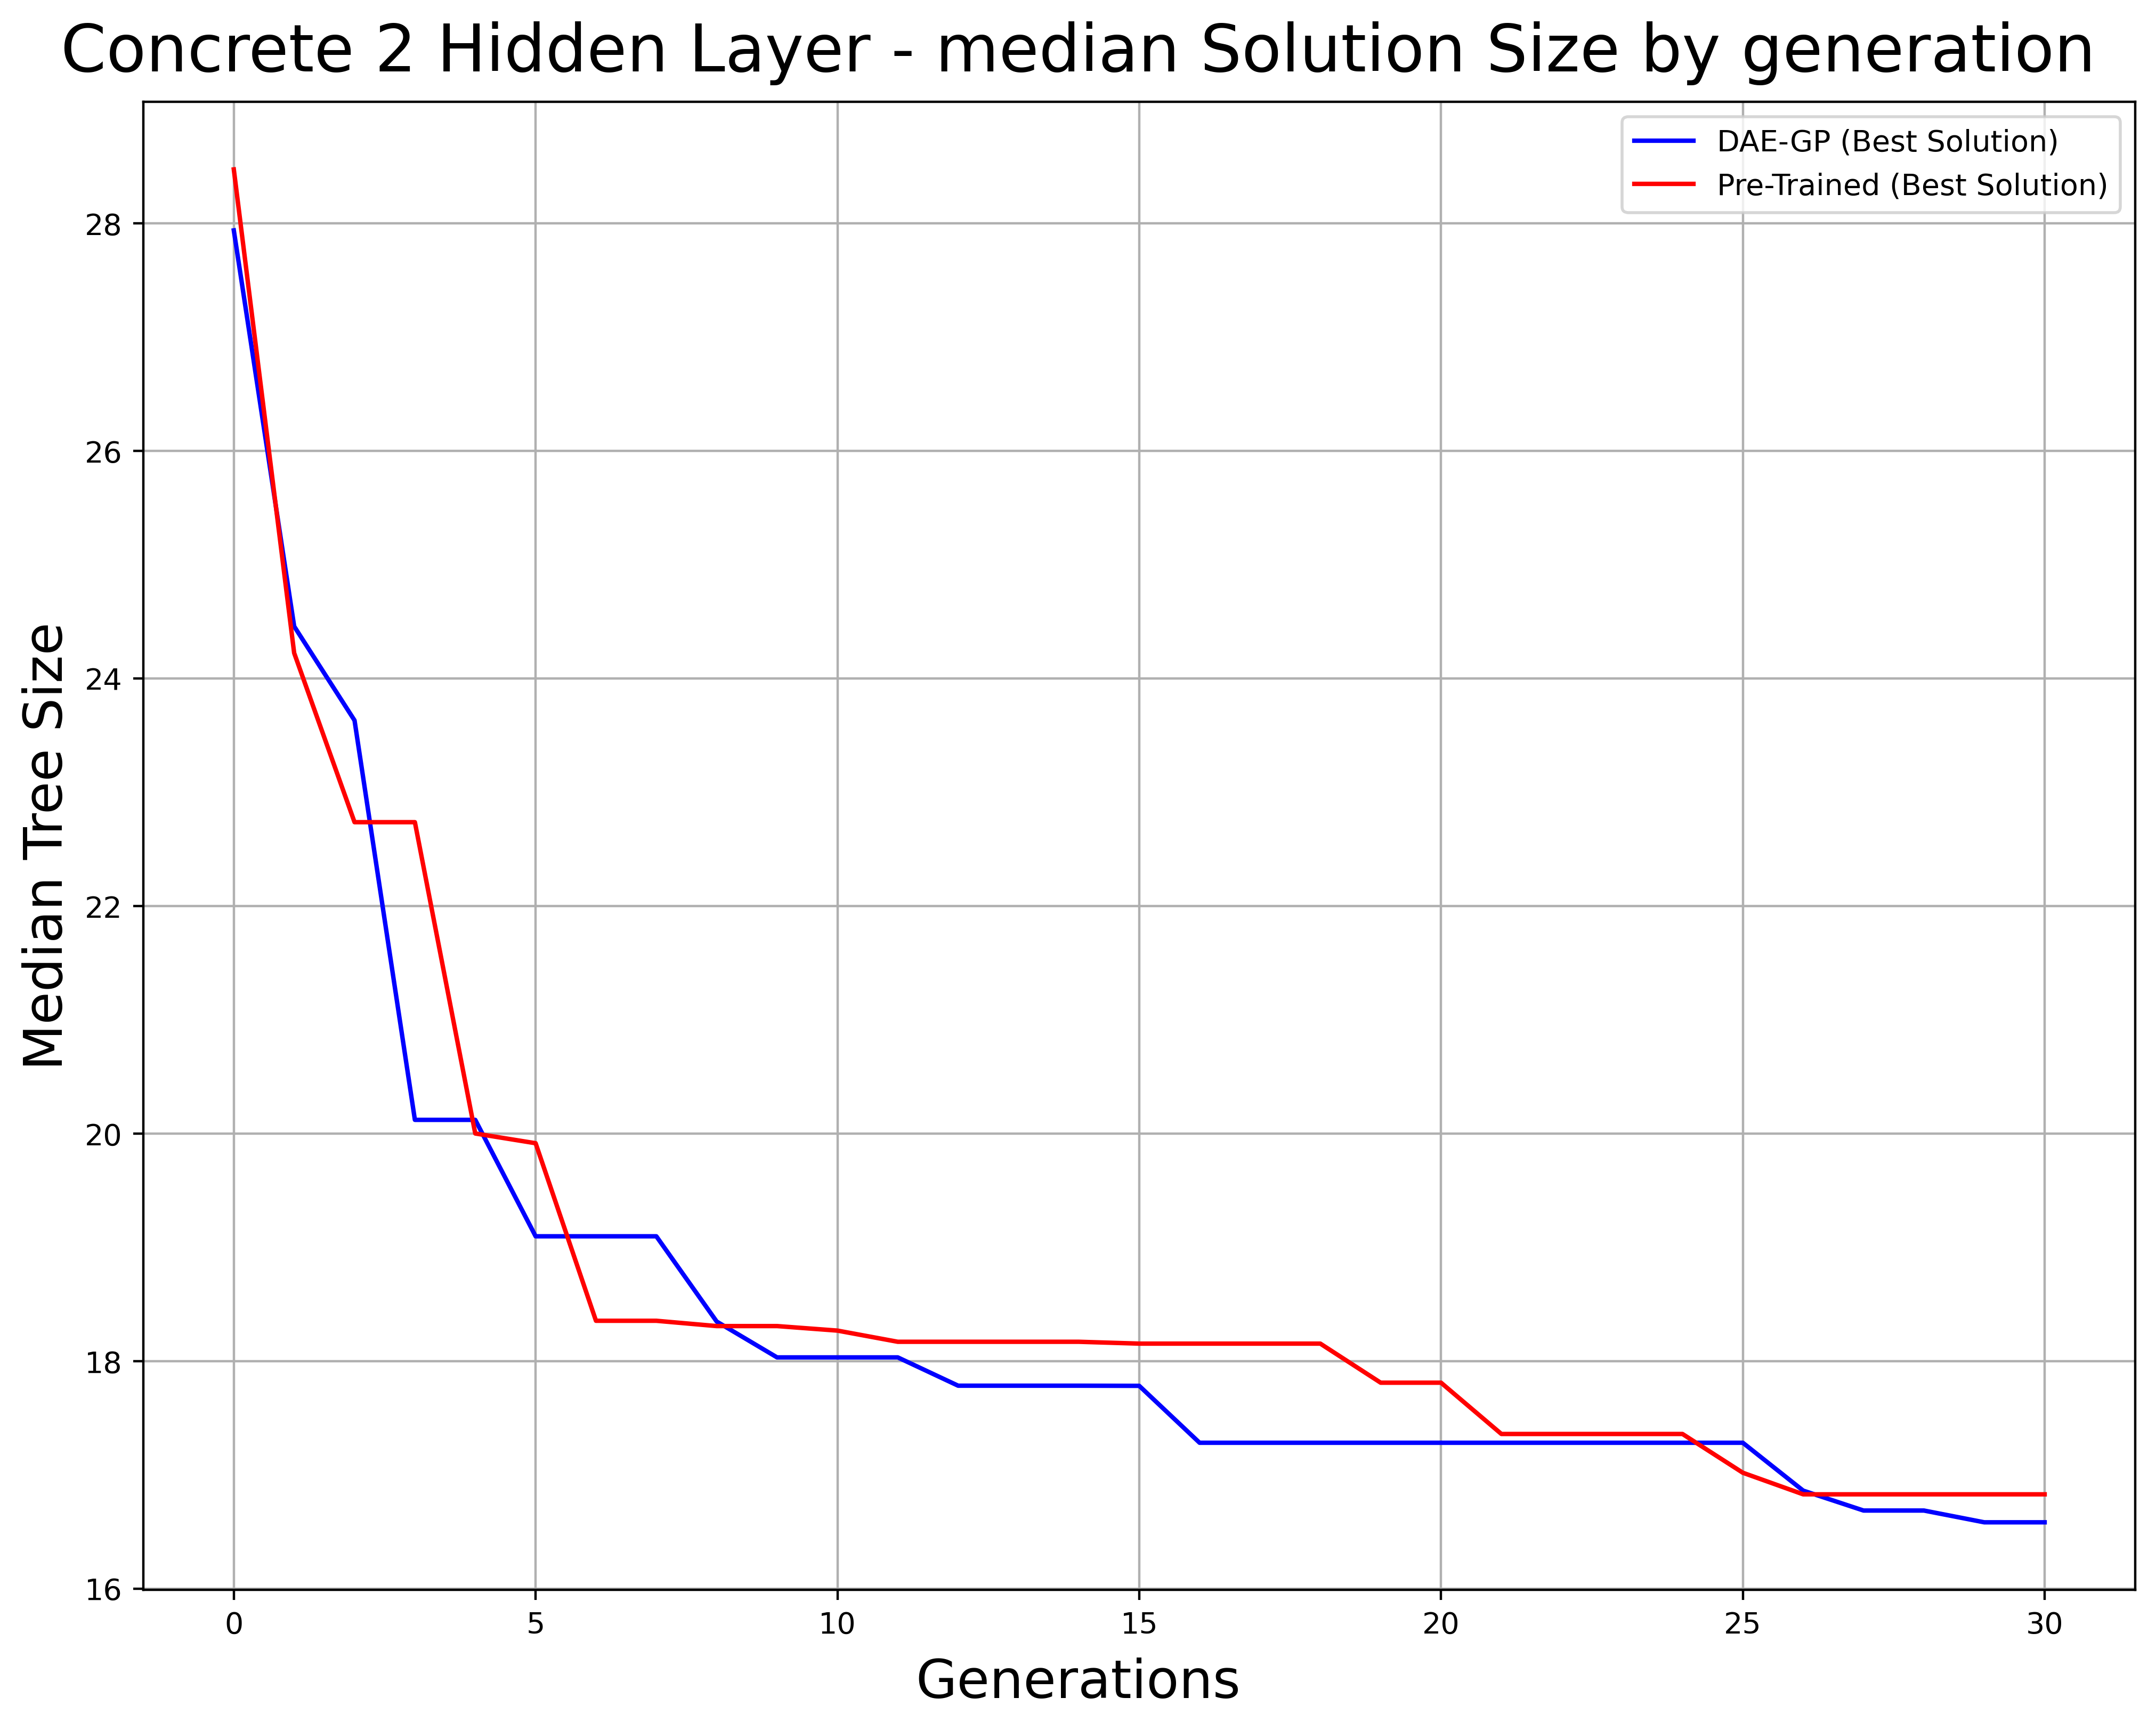

In [32]:
# plot median size


reg_avgsize = get_vals(reg_results, "avg_size", 30)
pt_avgsize = get_vals(pt_results, "avg_size", 30)

reg_bestsize = get_vals(reg_results, "size_best_fitness", 30)
pt_bestsize = get_vals(pt_results, "size_best_fitness", 30)

reg_avgsize_median = get_medians(reg_avgsize)
pt_avgsize_median = get_medians(pt_avgsize)

reg_bestsize_median = get_medians(reg_bestsize)
pt_bestsize_median = get_medians(pt_bestsize)

# reg_avgsize_median = get_medians(reg_avgsize)
# pt_avgsize_median = get_medians(pt_avgsize)

# reg_bestsize_median = get_medians(reg_bestsize)
# pt_bestsize_median = get_medians(pt_bestsize)




fig, (axl) = plt.subplots(layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(10,8)
gens = [x for x in range(0, 31)]

# ax.set_ylim(bottom=0)
# ax.set_xlim(left=0)


fig.suptitle(f"{BASE_TITLE} - median Solution Size by generation", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axl.set_ylabel("Median Tree Size", fontsize=MID)
axl.plot(gens, reg_bestsize_median, color=C_REG, label="DAE-GP (Best Solution)")
# axl.plot(gens, reg_avgsize_median, color=C_REG,linestyle=TRAIN_LINESTYLE, label="DAE-GP (Population average)")

axl.plot(gens, pt_bestsize_median, color=C_PT, label="Pre-Trained (Best Solution)")
# axl.plot(gens, pt_avgsize_median, color=C_PT, linestyle=TRAIN_LINESTYLE, label="Pre-Trained (Population average)")



axl.grid()

axl.legend()


fig.savefig(f"{IMG_PATH}/median_Size_byGens.png")

D = {
    "problem": "Concrete",
    "hiddenLayer": 2,
    "DAE-GP" : last_fits(reg_bestsize),
    "Pre-Trained" : last_fits(pt_bestsize)
}

writeData(DATAPATH, "median_size_best_solution", D)

In [26]:
import datetime

def print_current_date_and_time():
  now = datetime.datetime.now()
  print(f'Notebook last executed at: {now.strftime("%Y-%m-%d %H:%M:%S")}')

print_current_date_and_time()


Notebook last executed at: 2023-01-15 12:37:48
